In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Q1
## Use of PERMNO vs. TICKERS:

PERMNO is a unique identifier assigned by the Center for Research in Security Prices (CRSP) to each security in the market. It is used in academic and research settings because it provides a consistent way to track securities over time, regardless of changes in ticker symbols, company names, or corporate actions such as mergers and acquisitions. This consistency is crucial for historical analysis over long periods, as it allows for the unambiguous identification of securities.

TICKERS, on the other hand, are symbols assigned to securities traded on public exchanges. These can change over time due to various reasons, such as rebranding, mergers, or moving between exchanges, which can create confusion in longitudinal studies.

The choice of PERMNO over tickers for the dataset is likely aimed at ensuring consistency and accuracy in tracking the performance and characteristics of securities over time, especially in a dataset that spans several years.

# Q2
## Discrepancies between One-Month Price Change and PRC Column:

a. This discrepancy is not necessarily a data error. The PRC column typically represents the end-of-month stock price, while the one-month percent change in price is calculated based on the price change from the previous month to the current month. Several factors can cause these numbers to diverge, including stock splits, dividends, and other corporate actions that affect the stock price but are not reflected in the simple price listed.

b. For some companies, these columns may always be equal due to the absence of such corporate actions during the period in question or because the stock's price changes purely reflect market trading without external adjustments. This uniformity could also be seen in companies with stable dividend policies or those that did not undergo any stock splits or similar adjustments during the period.

# Q3
## Variability in the Number of Companies:

The number of companies in the S&P 500 index does not always precisely equal 500 due to several factors, including mergers, acquisitions, bankruptcies, and the addition or removal of companies based on the market capitalization criteria set by the index. These events can cause the number of constituents to fluctuate temporarily until adjustments are made.

It's not a mistake but reflects the dynamic nature of the stock market and the index's composition adjustments to maintain its representation of the U.S. economy's leading companies.

# Q4

## 303 companies are present over the entire sample 
## 761 unique companies are in the sample

In [3]:
file_path = 'sp500raw.xlsx'
sp500_data = pd.read_excel(file_path)
sp500_data.drop(columns=['Unnamed: 0'], inplace =True)

display(sp500_data.head())

date_counts = sp500_data.groupby('permno').size()
full_presence_companies = date_counts[date_counts == sp500_data['date'].nunique()]

unique_companies = sp500_data['permno'].nunique()

(full_presence_companies.count(), unique_companies)

permno       date  price   shrout       prc         mcap
0   43449 2011-01-31  73.67  1056507 -0.040255  77832870.69
1   13688 2011-01-31  46.28   392066 -0.032609  18144814.48
2   90071 2011-01-31  20.75   247197  0.061924   5129337.75
3   86580 2011-01-31  23.92   588556  0.553247  14078259.52
4   10225 2011-01-31  61.68   152581  0.023734   9411196.08

(303, 761)

# Q5



First, we plot the time series of market cap for all stocks each month

<Axes: title={'center': 'Different percentile for market cap'}, xlabel='date', ylabel='mcap'>

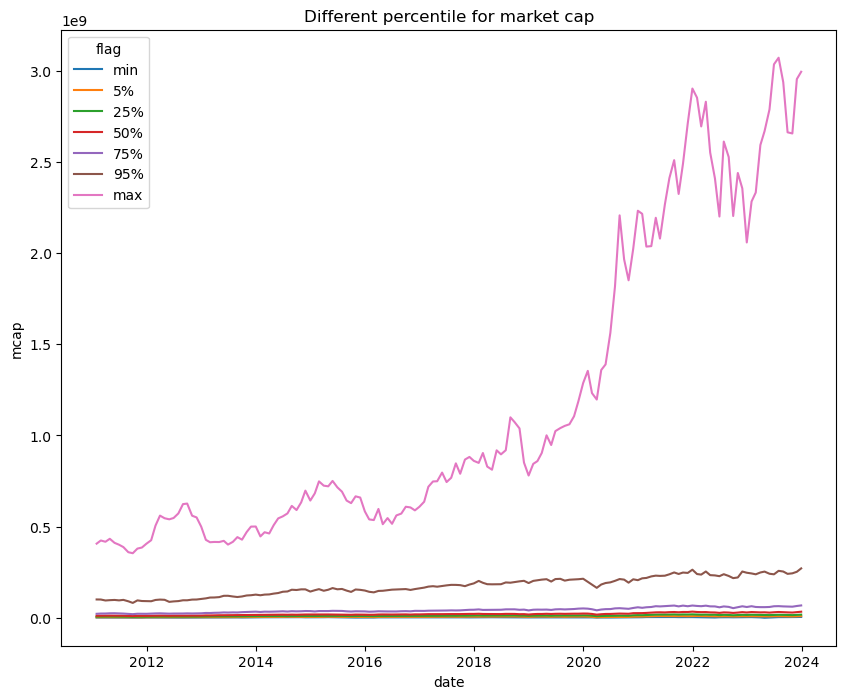

In [4]:
mcap_plot = sp500_data.groupby('date')['mcap'].describe(percentiles=[0.05,0.25,0.75,0.95]).reset_index()

col_plot = ['min', '5%', '25%', '50%', '75%', '95%','max']
df_list = []
for i in col_plot:
    tmp_df = mcap_plot[['date',i]]
    tmp_df['flag'] = i
    tmp_df.rename(columns={i:'mcap'},inplace=True)
    df_list.append(tmp_df)
mcap_final = pd.concat(df_list,axis=0)

plt.figure(figsize=(10,8))
plt.title('Different percentile for market cap')
sns.lineplot(data=mcap_final,x = 'date',y = 'mcap',hue='flag')


Calculate the percentile range for stock entering and leaving

In [5]:
sp500_data['rank'] = sp500_data.groupby(['date'])['mcap'].rank(ascending=True,pct=True)

first_mth = pd.DataFrame(sp500_data.groupby('permno')['date'].min()).reset_index()
last_mth = pd.DataFrame(sp500_data.groupby('permno')['date'].max()).reset_index()

first_mcap = pd.merge(first_mth,sp500_data[['permno','date','mcap','rank']],on=['permno','date'],how='left').rename(columns={'date':'first_date','mcap':'first_mcap','rank':'first_rank'})
last_mcap = pd.merge(last_mth,sp500_data[['permno','date','mcap','rank']],on=['permno','date'],how='left').rename(columns={'date':'last_date','mcap':'last_mcap','rank':'last_rank'})
mcap_each = pd.merge(first_mcap,last_mcap,on='permno',how='outer')
mcap_each

permno first_date    first_mcap  first_rank  last_date     last_mcap  \
0     10104 2011-01-31  1.618290e+08    0.976000 2023-12-29  2.898188e+08   
1     10107 2011-01-31  2.329560e+08    0.996000 2023-12-29  2.794828e+09   
2     10137 2011-01-31  4.381027e+06    0.118000 2011-01-31  4.381027e+06   
3     10138 2011-01-31  1.705746e+07    0.672000 2023-12-29  2.406548e+07   
4     10145 2011-01-31  4.369749e+07    0.884000 2023-12-29  1.382515e+08   
..      ...        ...           ...         ...        ...           ...   
756   93159 2012-07-31  1.260407e+07    0.536000 2016-02-29  2.039826e+06   
757   93246 2021-03-31  2.058384e+07    0.354455 2023-12-29  7.939472e+06   
758   93422 2011-01-31  7.137237e+06    0.282000 2015-06-30  3.269995e+06   
759   93429 2017-03-31  9.083326e+06    0.142574 2023-12-29  1.884808e+07   
760   93436 2020-12-31  6.773402e+08    0.994059 2023-12-29  7.898983e+08   

     last_rank  
0     0.958250  
1     0.998012  
2     0.118000  
3     0.399602  
4     0.882704  
..         ...  
756   0.005952  
757   0.027833  
758   0.001996  
759   0.292247  
760   0.988072  

[761 rows x 7 columns]

Then we'll calculate the trailing return for each company

In [6]:
sp500_data_cal = sp500_data.copy()

In [7]:
sp500_data_cal.sort_values(by=['permno','date'],ascending=True,inplace=True)


In [8]:
sp500_data.reset_index(inplace=True)
sp500_data.reset_index(inplace=True)

In [9]:
sp500_data_cal['prc_shift'] = sp500_data_cal['prc'].shift()
sp500_data_cal['price_shift'] = sp500_data_cal['price'].shift()

In [10]:
PRC_Ret_T12 = pd.DataFrame((sp500_data_cal.groupby('permno')['prc'].rolling(12).apply(lambda x:np.prod(1 + x) - 1 , raw=True))).reset_index()
PRC_Ret_T12_result = pd.merge(PRC_Ret_T12,sp500_data[['level_0','permno','date']],left_on = ['permno','level_1'],right_on=['permno','level_0'],how = 'left')

Prices_Ret_T1 = pd.DataFrame((sp500_data_cal.groupby('permno')['price'].rolling(2).apply(lambda x:x[-1] / x[0] - 1, raw=True))).reset_index()
Prices_Ret_T1_result = pd.merge(Prices_Ret_T1,sp500_data[['level_0','permno','date']],left_on = ['permno','level_1'],right_on=['permno','level_0'],how = 'left')

Prices_Ret_T12 = pd.DataFrame((sp500_data_cal.groupby('permno')['price'].rolling(12).apply(lambda x:x[-1] / x[0] - 1, raw=True))).reset_index()
Prices_Ret_T12_result = pd.merge(Prices_Ret_T12,sp500_data[['level_0','permno','date']],left_on = ['permno','level_1'],right_on=['permno','level_0'],how = 'left')

In [11]:
PRC_Ret_T12M1 = pd.DataFrame((sp500_data_cal.groupby('permno')['prc_shift'].rolling(11).apply(lambda x:np.prod(1 + x) - 1 , raw=True))).reset_index()
PRC_Ret_T12M1_result = pd.merge(PRC_Ret_T12M1,sp500_data[['level_0','permno','date']],left_on = ['permno','level_1'],right_on=['permno','level_0'],how = 'left')

Prices_Ret_T12M1 = pd.DataFrame((sp500_data_cal.groupby('permno')['price_shift'].rolling(11).apply(lambda x:x[-1] / x[0] - 1, raw=True))).reset_index()
Prices_Ret_T12M1_result = pd.merge(Prices_Ret_T12M1,sp500_data[['level_0','permno','date']],left_on = ['permno','level_1'],right_on=['permno','level_0'],how = 'left')

In [12]:
PRC_Ret_T12_M1 = pd.DataFrame((sp500_data_cal.groupby('permno')['prc'].rolling(12).apply(lambda x:x[0] , raw=True))).reset_index()
PRC_Ret_T12_M1_result = pd.merge(PRC_Ret_T12_M1,sp500_data[['level_0','permno','date']],left_on = ['permno','level_1'],right_on=['permno','level_0'],how = 'left')
Prices_Ret_T12_M1 = pd.DataFrame((sp500_data_cal.groupby('permno')['price'].rolling(13).apply(lambda x:x[1]/x[0]-1 , raw=True))).reset_index()
Prices_Ret_T12_M1_result = pd.merge(Prices_Ret_T12_M1,sp500_data[['level_0','permno','date']],left_on = ['permno','level_1'],right_on=['permno','level_0'],how = 'left')

In [13]:
# Vol_Prices_Ret_T12M1 = Prices_Ret_T12M1_result.groupby('permno')['price_shift'].std()
Vol_Prices_Ret_T12M1 = pd.DataFrame(Prices_Ret_T12M1_result.groupby('permno')['price_shift'].std()).reset_index()

there exist some nan in volatility of Prices_Ret_T12M1 because the recording months are less than 12 months

In [14]:
SR_Prices_Ret_T12M1 = pd.merge(Vol_Prices_Ret_T12M1,Prices_Ret_T12M1_result[['permno','date','price_shift']],on='permno',how='right')
SR_Prices_Ret_T12M1['SR_Prices_Ret'] = SR_Prices_Ret_T12M1['price_shift_y']/SR_Prices_Ret_T12M1['price_shift_x']

Then calculate the forward return

In [15]:
sp500_data_cal['prc_shift-1'] = sp500_data_cal['prc'].shift(-1)
PRC_Ret_F1M_result = sp500_data_cal[['permno','date','prc_shift-1']]
PRC_Ret_F3M = pd.DataFrame((sp500_data_cal.groupby('permno')['prc'].rolling(3).apply(lambda x:np.prod(1 + x) - 1 , raw=True))).shift(-3).reset_index()
PRC_Ret_F3M_result = pd.merge(PRC_Ret_F3M,sp500_data[['level_0','permno','date']],left_on = ['permno','level_1'],right_on=['permno','level_0'],how = 'left')
PRC_Ret_F6M = pd.DataFrame((sp500_data_cal.groupby('permno')['prc'].rolling(6).apply(lambda x:np.prod(1 + x) - 1 , raw=True))).shift(-6).reset_index()
PRC_Ret_F6M_result = pd.merge(PRC_Ret_F6M,sp500_data[['level_0','permno','date']],left_on = ['permno','level_1'],right_on=['permno','level_0'],how = 'left')

In [16]:
result_df = SR_Prices_Ret_T12M1[['permno','date','SR_Prices_Ret']]
result_df['Prices_Ret_T1']  = Prices_Ret_T1_result['price']
result_df['PRC_Ret_T12'] = PRC_Ret_T12_result['prc']
result_df['Prices_Ret_T12'] = Prices_Ret_T12_result['price']
result_df['PRC_Ret_T12M1'] = PRC_Ret_T12M1_result['prc_shift']
result_df['Prices_Ret_T12M1'] = Prices_Ret_T12M1_result['price_shift']
result_df['PRC_Ret_T12_M1'] = PRC_Ret_T12_M1_result['prc']
result_df['Prices_Ret_T12_M1'] = Prices_Ret_T12_M1_result['price']
result_df['PRC_Ret_F1M'] = PRC_Ret_F1M_result['prc_shift-1']
result_df['PRC_Ret_F3M'] = PRC_Ret_F3M_result['prc']
result_df['PRC_Ret_F6M'] = PRC_Ret_F6M_result['prc']

In [17]:
result_df

permno       date  SR_Prices_Ret  Prices_Ret_T1  PRC_Ret_T12  \
0       10104 2011-01-31            NaN            NaN          NaN   
1       10104 2011-02-28            NaN       0.027162          NaN   
2       10104 2011-03-31            NaN       0.016185          NaN   
3       10104 2011-04-29            NaN       0.075600          NaN   
4       10104 2011-05-31            NaN      -0.048387          NaN   
...       ...        ...            ...            ...          ...   
78476   93436 2023-08-31       0.009455      -0.034962    -0.063603   
78477   93436 2023-09-29       0.154411      -0.030456    -0.056662   
78478   93436 2023-10-31       0.328059      -0.197346    -0.117340   
78479   93436 2023-11-30       0.725313       0.195379     0.233078   
78480   93436 2023-12-29       0.444055       0.034988     1.017211   

       Prices_Ret_T12  PRC_Ret_T12M1  Prices_Ret_T12M1  PRC_Ret_T12_M1  \
0                 NaN            NaN               NaN             NaN   
1                 NaN            NaN               NaN             NaN   
2                 NaN            NaN               NaN             NaN   
3                 NaN            NaN               NaN             NaN   
4                 NaN            NaN               NaN             NaN   
...               ...            ...               ...             ...   
78476       -0.027031      -0.029678          0.008219       -0.037589   
78477        0.099675      -0.027030          0.134218       -0.142168   
78478        0.031536       0.099676          0.285157       -0.144326   
78479        0.949018       0.031537          0.630459       -0.367334   
78480        0.434476       0.949019          0.385983        0.406235   

       Prices_Ret_T12_M1  PRC_Ret_F1M  PRC_Ret_F3M  PRC_Ret_F6M  
0                    NaN     0.035564     0.124570    -0.041801  
1                    NaN    -0.004754     0.041857    -0.143709  
2                    NaN    -0.036627    -0.013986    -0.137234  
3                    NaN    -0.052676    -0.147942    -0.085250  
4                    NaN     0.005999    -0.178110    -0.080391  
...                  ...          ...          ...          ...  
78476          -0.037589    -0.029942    -0.069746          NaN  
78477          -0.142168     0.061608    -0.006954          NaN  
78478          -0.144326     0.043382          NaN          NaN  
78479          -0.367334     0.080934          NaN          NaN  
78480           0.406235     0.043118          NaN          NaN  

[78481 rows x 13 columns]

# Q6

plot the time series of different variables

In [18]:
var_list = ['SR_Prices_Ret', 'PRC_Ret_T12', 'Prices_Ret_T12',
       'PRC_Ret_T12M1', 'Prices_Ret_T12M1', 'PRC_Ret_T12_M1',
       'Prices_Ret_T12_M1', 'PRC_Ret_F1M', 'PRC_Ret_F3M', 'PRC_Ret_F6M']

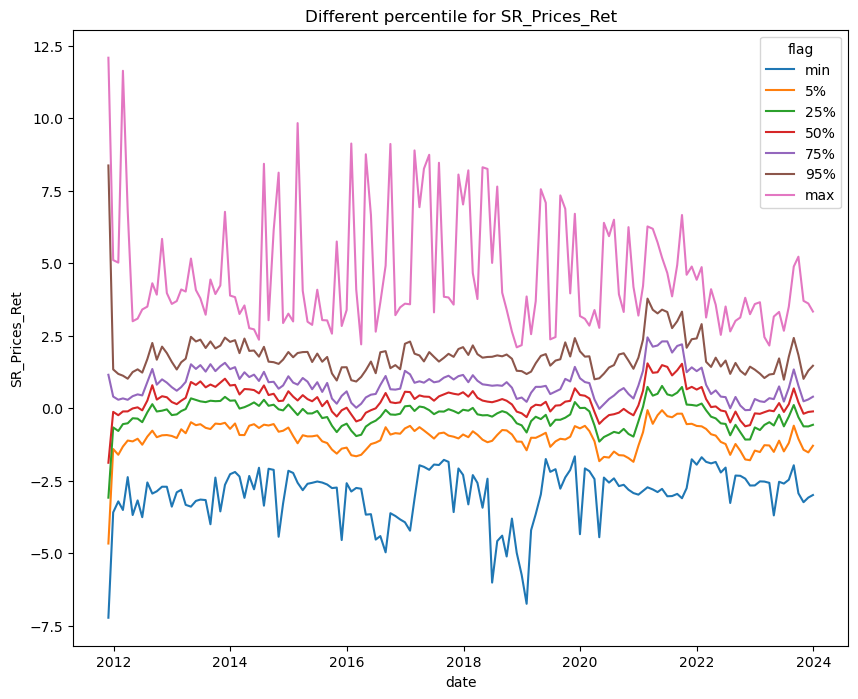

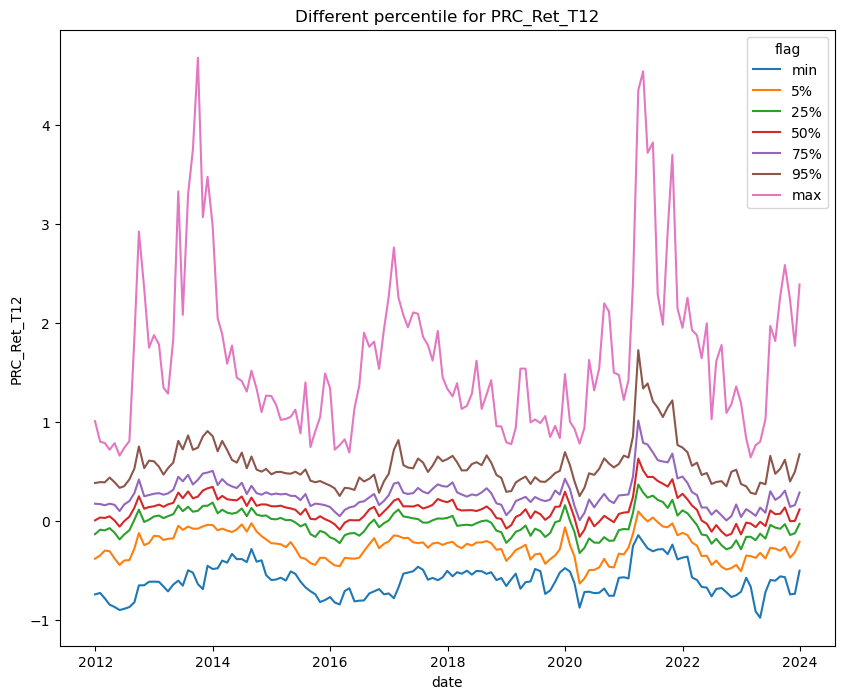

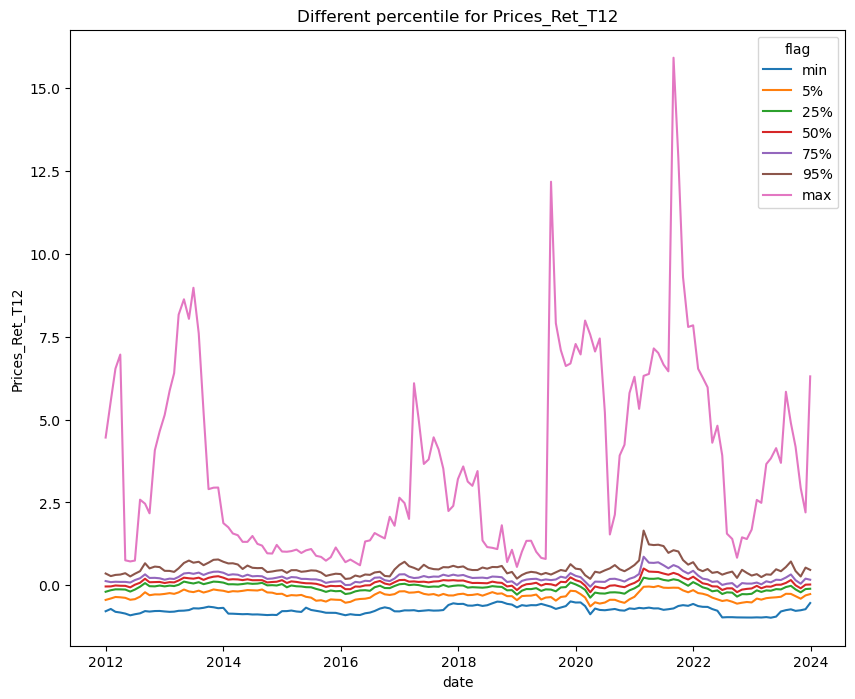

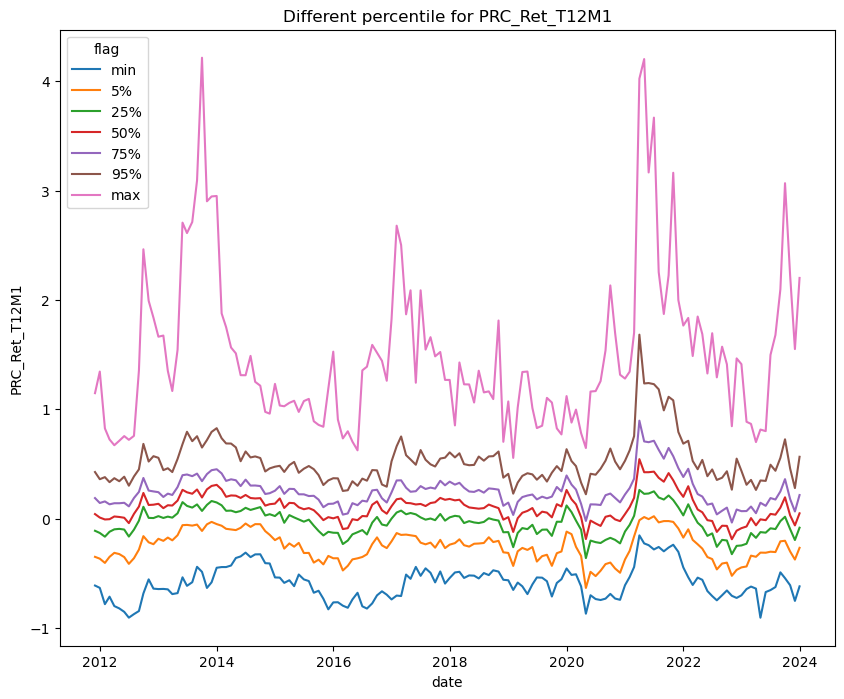

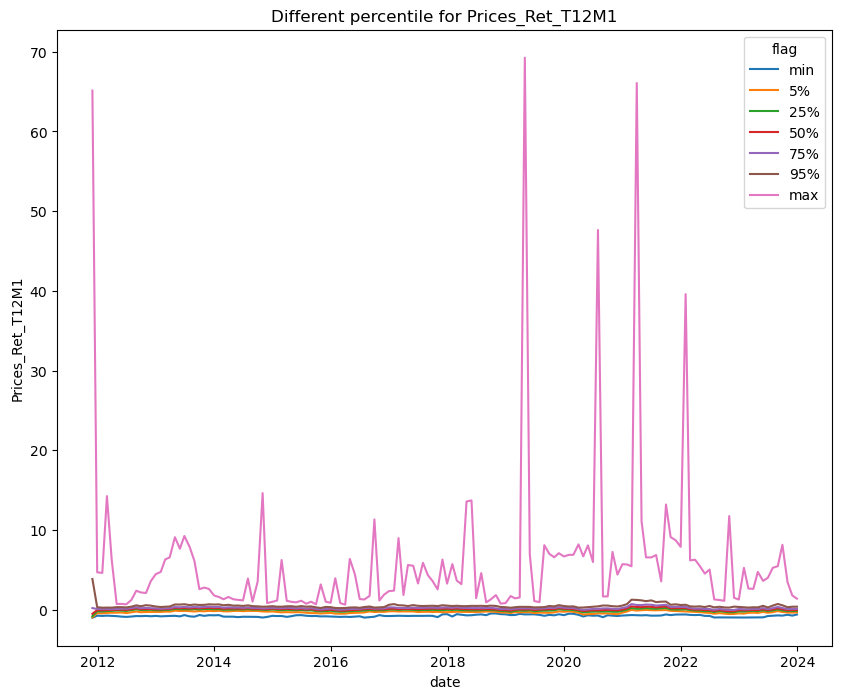

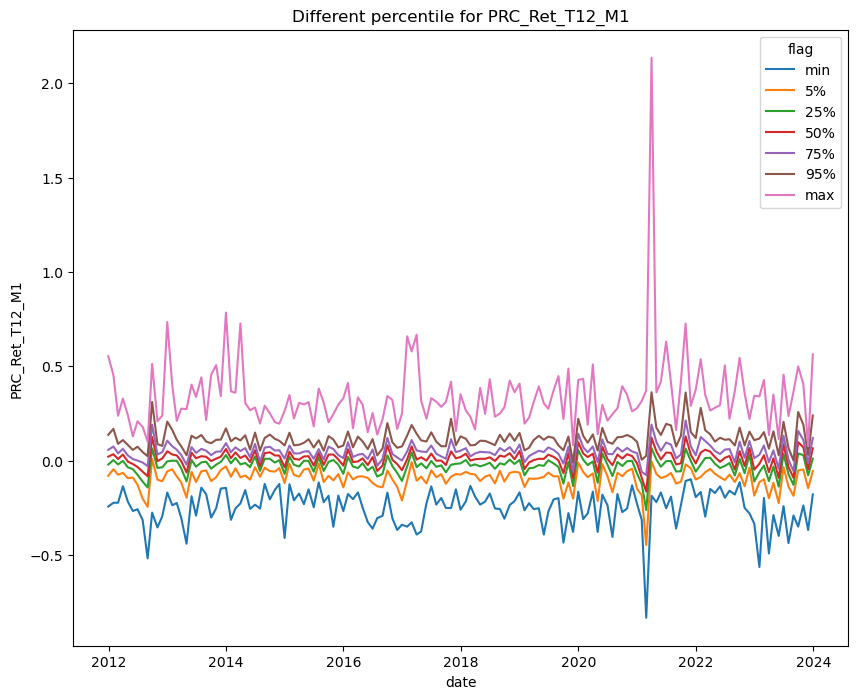

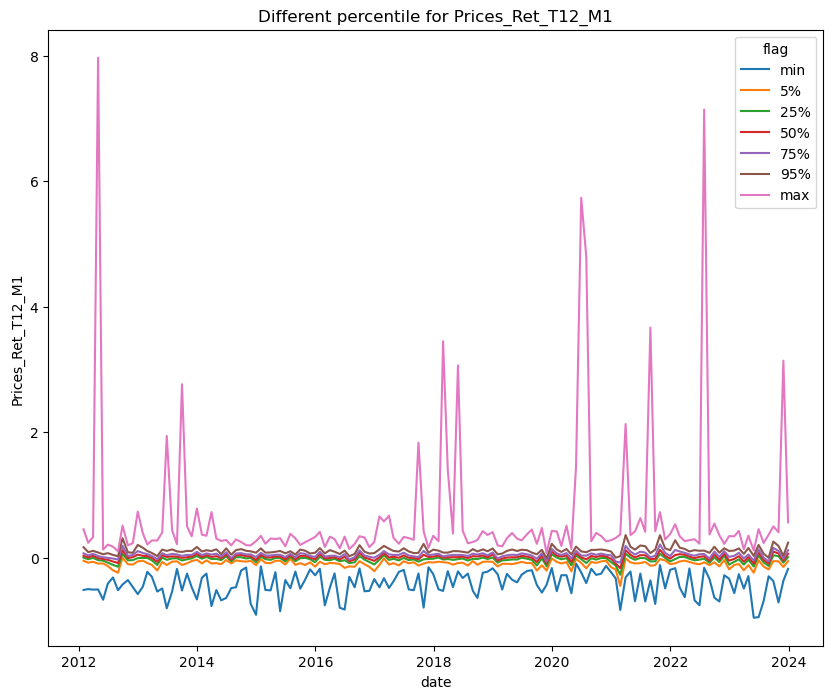

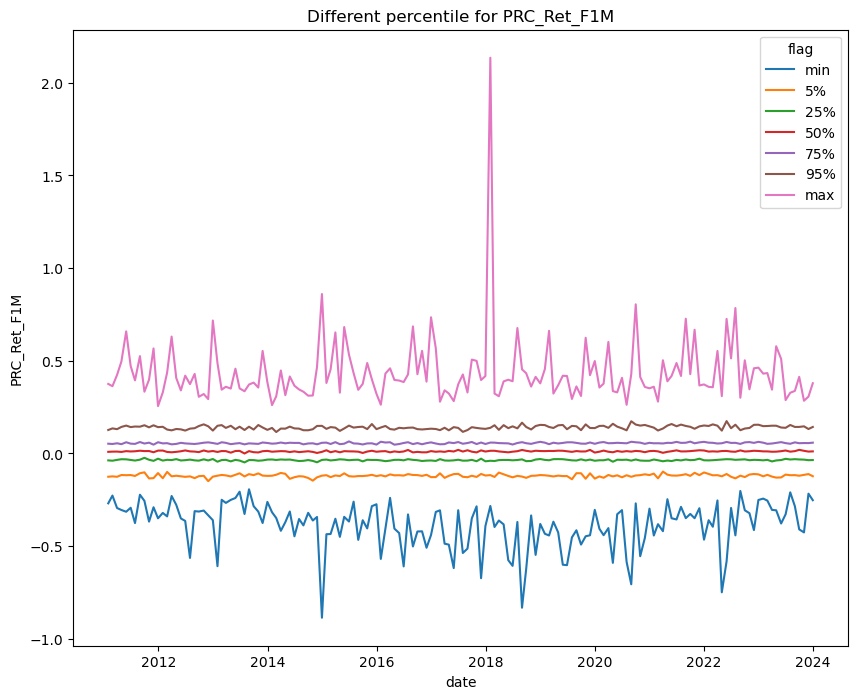

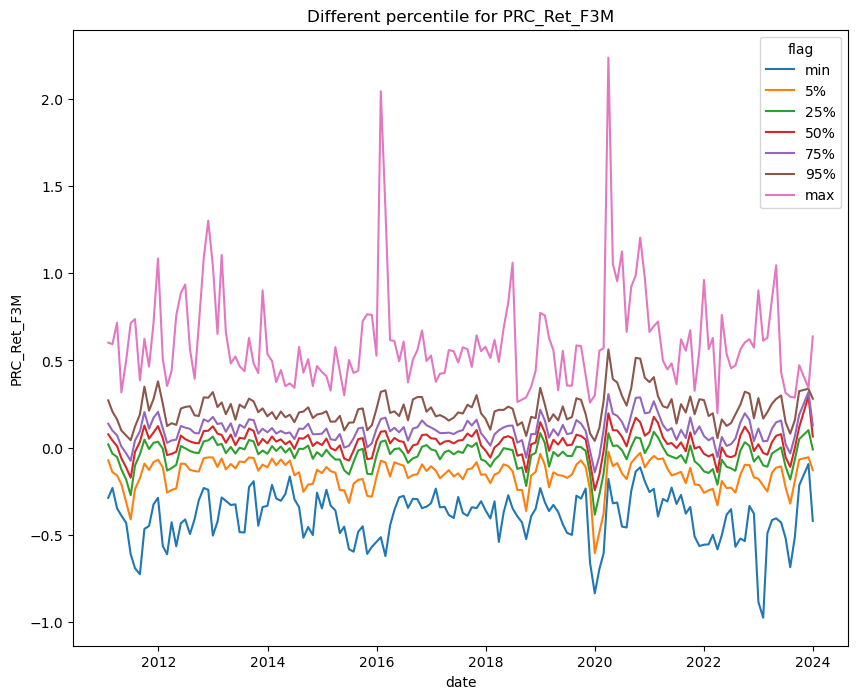

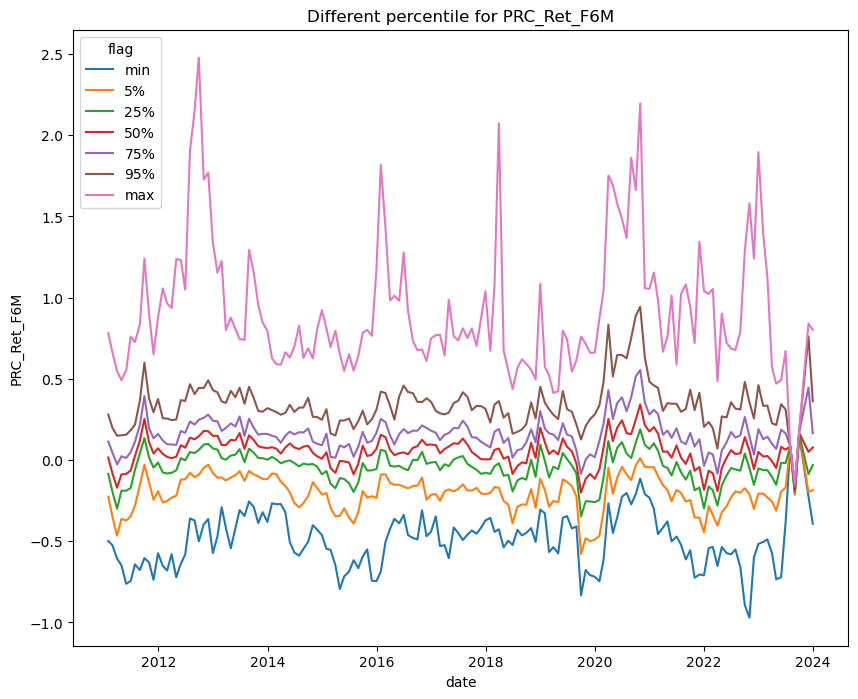

In [19]:

for j in var_list:
    var_plot = result_df.groupby('date')[j].describe(percentiles=[0.05,0.25,0.75,0.95]).reset_index()

    col_plot = ['min', '5%', '25%', '50%', '75%', '95%','max']
    df_list = []
    for i in col_plot:
        tmp_df = var_plot[['date',i]]
        tmp_df['flag'] = i
        tmp_df.rename(columns={i:j},inplace=True)
        df_list.append(tmp_df)
    var_final = pd.concat(df_list,axis=0)
    cleaned_df = var_final.dropna()
    # print(var_final)
    plt.figure(figsize=(10,8))
    plt.title(f'Different percentile for {j}')
    # print(j)
    sns.lineplot(data=cleaned_df,x = 'date',y = j,hue='flag')


# Q7

In [20]:
regress_df = result_df.copy()
regress_df2 = result_df.copy()
# regress_df.set_index(['permno','date'],inplace=True)

In [21]:
regress_df

permno       date  SR_Prices_Ret  Prices_Ret_T1  PRC_Ret_T12  \
0       10104 2011-01-31            NaN            NaN          NaN   
1       10104 2011-02-28            NaN       0.027162          NaN   
2       10104 2011-03-31            NaN       0.016185          NaN   
3       10104 2011-04-29            NaN       0.075600          NaN   
4       10104 2011-05-31            NaN      -0.048387          NaN   
...       ...        ...            ...            ...          ...   
78476   93436 2023-08-31       0.009455      -0.034962    -0.063603   
78477   93436 2023-09-29       0.154411      -0.030456    -0.056662   
78478   93436 2023-10-31       0.328059      -0.197346    -0.117340   
78479   93436 2023-11-30       0.725313       0.195379     0.233078   
78480   93436 2023-12-29       0.444055       0.034988     1.017211   

       Prices_Ret_T12  PRC_Ret_T12M1  Prices_Ret_T12M1  PRC_Ret_T12_M1  \
0                 NaN            NaN               NaN             NaN   
1                 NaN            NaN               NaN             NaN   
2                 NaN            NaN               NaN             NaN   
3                 NaN            NaN               NaN             NaN   
4                 NaN            NaN               NaN             NaN   
...               ...            ...               ...             ...   
78476       -0.027031      -0.029678          0.008219       -0.037589   
78477        0.099675      -0.027030          0.134218       -0.142168   
78478        0.031536       0.099676          0.285157       -0.144326   
78479        0.949018       0.031537          0.630459       -0.367334   
78480        0.434476       0.949019          0.385983        0.406235   

       Prices_Ret_T12_M1  PRC_Ret_F1M  PRC_Ret_F3M  PRC_Ret_F6M  
0                    NaN     0.035564     0.124570    -0.041801  
1                    NaN    -0.004754     0.041857    -0.143709  
2                    NaN    -0.036627    -0.013986    -0.137234  
3                    NaN    -0.052676    -0.147942    -0.085250  
4                    NaN     0.005999    -0.178110    -0.080391  
...                  ...          ...          ...          ...  
78476          -0.037589    -0.029942    -0.069746          NaN  
78477          -0.142168     0.061608    -0.006954          NaN  
78478          -0.144326     0.043382          NaN          NaN  
78479          -0.367334     0.080934          NaN          NaN  
78480           0.406235     0.043118          NaN          NaN  

[78481 rows x 13 columns]

## Regression for Nov. 2019
- **Economic Interpretation:** The coefficient for PRC_Ret_T12M1 (0.0361) suggests a positive relationship between past returns (excluding the most recent month) and future returns, indicating that stocks with higher past returns tend to have higher future returns in this period. This is a classic momentum effect.
- **Statistical Interpretation:** The coefficient is statistically significant at the 10% level (p-value = 0.046), although it's not as strong as a 5% or 1% significance level. The low R-squared value (0.008) indicates that the model explains a very small portion of the variability of the dependent variable.

In [22]:
import pandas as pd
import statsmodels.api as sm
import datetime

november_data = result_df[result_df.date == datetime.datetime(2019,11,29)]
november_data.dropna(axis=0,inplace=True)

X = november_data['PRC_Ret_T12M1']  
X = sm.add_constant(X)
Y = november_data['PRC_Ret_F1M']  

# Run the regression
model = sm.OLS(Y, X).fit()

print(model.summary())



                            OLS Regression Results                            
Dep. Variable:            PRC_Ret_F1M   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.986
Date:                Tue, 02 Apr 2024   Prob (F-statistic):             0.0465
Time:                        16:56:49   Log-Likelihood:                 495.25
No. Observations:                 477   AIC:                            -986.5
Df Residuals:                     475   BIC:                            -978.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0100      0.004      2.292

## Regression for the entire sample
- **Economic Interpretation:** the coefficient for PRC_Ret_T12M1 (0.0049) suggests a positive momentum effect but the effect size is smaller compared to the November 2019 regression.
- **Statistical Interpretation:** The coefficient is significant at the 10% level (p-value = 0.0137), indicating some evidence of a momentum effect across the entire sample. The adjusted R-squared (0.04%) is extremely low, indicating that the model does not explain much of the variability in returns
    
- **Explanation:**
    - Using Momentum [-12, -1] as an investment strategy seems to have some merit, given the positive coefficients in both regressions. However, the low R-squared values suggest that other factors are also at play in explaining returns, and the momentum effect alone is not a strong predictor.
    - The consistency of results across time is low, indicated by the low R-squared values. The periods that stand out are those where the coefficient is significant, suggesting that during certain times, past performance can be a reasonable indicator of future performance.

 
    
      
    

**Performance Measures Commentary:**

- In the context of momentum strategies, measures such as hit rates (the percentage of positive returns), draw-downs (the peak-to-trough decline during a specific record period of an investment), and max draw-down (the maximum observed loss from a peak to a trough) can be particularly salient.
- The Sortino ratio, which is a variation of the Sharpe ratio that differentiates harmful volatility from total overall volatility by using the asset's standard deviation of negative portfolio returns, called downside deviation, could be a useful measure for a momentum strategy since it focuses on the downside risk.
- The interpretation of the single regression coefficient in both regressions suggests that past performance can have a positive effect on future returns, which is the basis for a momentum strategy. However, the small size of the coefficients and the low explanatory power of the model (R-squared) suggest that this strategy should be applied with caution.
- The time-series of the regression coefficients could be viewed to assess the stability and consistency of the momentum effect over time. If the coefficients vary widely over time, it could suggest that the momentum effect is not stable.

In [23]:
regress_df.dropna(axis=0,inplace=True)
unique_year_months = regress_df['date'].unique()
sorted_unique_year_months = sorted(unique_year_months)

In [24]:
sorted_unique_year_months = sorted(unique_year_months)

In [25]:
coefficients = []
p_values = []

for period in sorted_unique_year_months:
    monthly_data = regress_df[regress_df['date'] == period]
    # monthly_data.dropna(subset=['PRC_Ret_T12M1', 'PRC_Ret_F1M'], inplace=True)
    
    if monthly_data.empty or len(monthly_data) < 2:
        coefficients.append(np.nan)
        p_values.append(np.nan)
        
    else:
        X = monthly_data['PRC_Ret_T12M1']
        X = sm.add_constant(X)
        Y = monthly_data['PRC_Ret_F1M']

        model = sm.OLS(Y, X).fit()

        coefficients.append(model.params['PRC_Ret_T12M1'])
        p_values.append(model.pvalues['PRC_Ret_T12M1'])



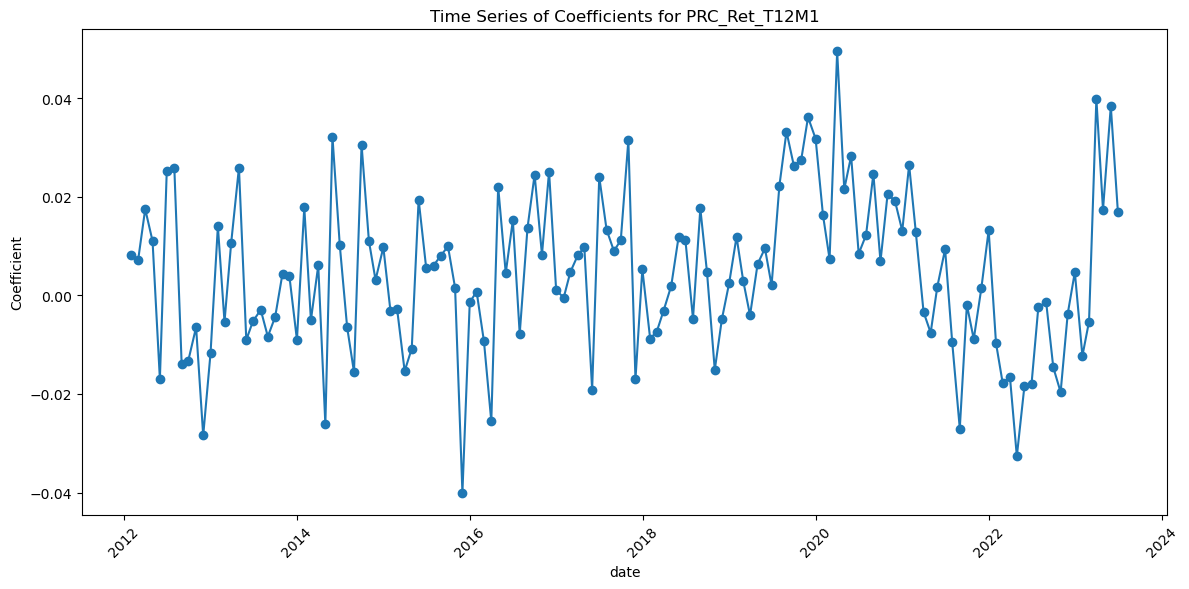

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(sorted_unique_year_months[:-5], coefficients[:-5], marker='o', linestyle='-')
plt.title('Time Series of Coefficients for PRC_Ret_T12M1')
plt.xlabel('date')
plt.ylabel('Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [27]:
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
from linearmodels import FamaMacBeth

def FamaMacBeth_summary(DF,
                        reg_lst,
                        reg_order,
                        reg_names=None,
                        params_format='{:.3f}',
                        tvalues_format='{:.2f}'):

    '''
    A function for Fama-MacBeth regression and results summary.

    Parameters
    ----------
    DF: DataFrame
        A panel date of which multi-index is stock and month (datetime64[ns]),
        containing all the dependent and independent variables.
    reg_lst: list
        A list containing multiple lists of dependent variable and independent
        variables, e.g., [['Y', 'X1', ...],..., ['Y', 'X1', ...,]].
    reg_order: list
        The order of independent variables in result table.
    reg_names: list
        The names for each regression.
    params_format: str
        The number of decimal places for parameters, e.g., '{:.3f}'.
    tvalues_format: str
        The number of decimal places for t-values, e.g., '{:.2f}'.
    '''

    # Create a DataFrame
    rows = sum([[var, f'{var}_t'] for var in ['const'] + reg_order], [])
    if reg_names is None:
        reg_names = [f'({i+1})' for i in range(len(reg_lst))]
    show = pd.DataFrame(index=rows, columns=reg_names)

    for reg, reg_name in zip(reg_lst, reg_names):
        df = DF.loc[:, reg].copy().dropna()
        T = len(df.index.get_level_values(df.index.names[1]).unique())
        lag = math.floor(4*(T/100)**(2/9))
        fmb = FamaMacBeth(df[reg[0]], sm.add_constant(df[reg[1:]]))

        
        # Newey-West adjust
        fmb = fmb.fit(cov_type='kernel', bandwidth=lag)
        # print(fmb.summary)
        # params, tvalues(tstats) and pvalues
        params = fmb.params
        tvalues = fmb.tstats
        pvalues = fmb.pvalues

        # Obs.
        total_obs = fmb.nobs
        # mean_obs = fmb.time_info['mean']

        # average rsquared_adj
        dft = df.reset_index(level=df.index.names[0], drop=True).copy()
        rsquared_adj = []
        for month in dft.index.unique():
            dftm = dft.loc[month].copy()
            ols = sm.OLS(dftm[reg[0]], sm.add_constant(dftm[reg[1:]])).fit()
            rsquared_adj.append(ols.rsquared_adj)
        ar2a = np.mean(rsquared_adj)

        # params and significance
        ps_lst = []
        for param, pvalue in zip(params, pvalues):
            param = params_format.format(param)
            if (pvalue <= 0.1) & (pvalue > 0.05):
                param = param + '*'
            elif (pvalue <= 0.05) & (pvalue > 0.01):
                param = param + '**'
            elif pvalue <= 0.01:
                param = param + '***'
            ps_lst.append(param)

        # params and tvalues
        tvalues = [tvalues_format.format(t) for t in tvalues]
        t_lst = [f'({t})' for t in tvalues]
        pt_lst = [[i, j] for i, j in zip(ps_lst, t_lst)]

        # put them in place
        for var, pt in zip(['const'] + reg[1:], pt_lst):
            show.loc[var, reg_name] = pt[0]
            show.loc[f'{var}_t', reg_name] = pt[1]
        show.loc['No. Obs.', reg_name] = str(total_obs)
        show.loc['Adj. R²', reg_name] = '{:.2f}%'.format(ar2a * 100)

    rename_index = sum([[var, ''] for var in ['Intercept'] + reg_order], [])
    # print(rename_index)
    # display(show)
    # show.index = rename_index + ['No. Obs.', 'Adj. R²']

    return show.dropna(axis=0, how='all').fillna('')

In [28]:

FamaMacBeth_summary(DF=regress_df2.set_index(['permno','date']),reg_lst=[['PRC_Ret_F1M','PRC_Ret_T12M1']],reg_order=[])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


(1)
const            0.010***
const_t           (23.64)
PRC_Ret_T12M1     0.005**
PRC_Ret_T12M1_t    (2.47)
No. Obs.            70898
Adj. R²             0.04%

# Q8

In [29]:
result_df_q8 = pd.merge(result_df,sp500_data[['permno','date','prc']],on = ['permno','date'],how = 'left')

In [30]:
var_list_q8 = ['SR_Prices_Ret', 'PRC_Ret_T12', 'Prices_Ret_T12','PRC_Ret_T12M1', 'Prices_Ret_T12M1', 'PRC_Ret_T12_M1','Prices_Ret_T12_M1', 'PRC_Ret_F1M', 'prc']

In [31]:
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
from linearmodels import FamaMacBeth

def FamaMacBeth_summary(DF,
                        reg_lst,
                        reg_order,
                        reg_names=None,
                        params_format='{:.3f}',
                        tvalues_format='{:.2f}'):

    '''
    A function for Fama-MacBeth regression and results summary.

    Parameters
    ----------
    DF: DataFrame
        A panel date of which multi-index is stock and month (datetime64[ns]),
        containing all the dependent and independent variables.
    reg_lst: list
        A list containing multiple lists of dependent variable and independent
        variables, e.g., [['Y', 'X1', ...],..., ['Y', 'X1', ...,]].
    reg_order: list
        The order of independent variables in result table.
    reg_names: list
        The names for each regression.
    params_format: str
        The number of decimal places for parameters, e.g., '{:.3f}'.
    tvalues_format: str
        The number of decimal places for t-values, e.g., '{:.2f}'.
    '''

    # Create a DataFrame
    rows = sum([[var, f'{var}_t'] for var in ['const'] + reg_order], [])
    if reg_names is None:
        reg_names = [f'({i+1})' for i in range(len(reg_lst))]
    show = pd.DataFrame(index=rows, columns=reg_names)

    for reg, reg_name in zip(reg_lst, reg_names):
        df = DF.loc[:, reg].copy().dropna()
        T = len(df.index.get_level_values(df.index.names[1]).unique())
        lag = math.floor(4*(T/100)**(2/9))
        fmb = FamaMacBeth(df[reg[0]], sm.add_constant(df[reg[1:]]))

        
        # Newey-West adjust
        fmb = fmb.fit(cov_type='kernel', bandwidth=lag)
        # print(fmb.summary)
        # params, tvalues(tstats) and pvalues
        params = fmb.params
        tvalues = fmb.tstats
        pvalues = fmb.pvalues

        # Obs.
        total_obs = fmb.nobs
        # mean_obs = fmb.time_info['mean']

        # average rsquared_adj
        dft = df.reset_index(level=df.index.names[0], drop=True).copy()
        rsquared_adj = []
        for month in dft.index.unique():
            # print(len(dft.loc[month]))
            dftm = dft.loc[month].copy()
            # print(len(pd.DataFrame(dftm).columns))
            # print(dftm)
            if isinstance(dftm,pd.Series):
                rsquared_adj.append(np.nan)
            else:
                ols = sm.OLS(dftm[reg[0]], sm.add_constant(dftm[reg[1:]])).fit()
                rsquared_adj.append(ols.rsquared_adj)
                # print('in')
                # print(ols.rsquared_adj)
        ar2a = np.nanmean(rsquared_adj)
        # print(ar2a)
        # print(rsquared_adj)

        # params and significance
        ps_lst = []
        for param, pvalue in zip(params, pvalues):
            param = params_format.format(param)
            if (pvalue <= 0.1) & (pvalue > 0.05):
                param = param + '*'
            elif (pvalue <= 0.05) & (pvalue > 0.01):
                param = param + '**'
            elif pvalue <= 0.01:
                param = param + '***'
            ps_lst.append(param)

        # params and tvalues
        tvalues = [tvalues_format.format(t) for t in tvalues]
        t_lst = [f'({t})' for t in tvalues]
        pt_lst = [[i, j] for i, j in zip(ps_lst, t_lst)]

        # put them in place
        for var, pt in zip(['const'] + reg[1:], pt_lst):
            show.loc[var, reg_name] = pt[0]
            show.loc[f'{var}_t', reg_name] = pt[1]
        show.loc['No. Obs.', reg_name] = str(total_obs)
        show.loc['Adj. R²', reg_name] = '{:.2f}%'.format(ar2a * 100)

    # no_obs_index = show.index("No. Obs.")
    # adj_r_squared_index = show.index("Adj. R²")

    # # 移除"No. Obs."和"Adj. R²"并保存它们的值
    # no_obs_data = show.pop(no_obs_index)
    # adj_r_squared_data = show.pop(adj_r_squared_index)

    # # 在数据末尾重新添加"No. Obs."和"Adj. R²"
    # show.append(no_obs_data)
    # show.append(adj_r_squared_data)
        


    # rename_index = sum([[var, ''] for var in ['Intercept'] + reg_order], [])
    # print(rename_index)
    # display(show)
    # show.index = rename_index + ['No. Obs.', 'Adj. R²']
    show = pd.concat([show[~show.index.isin(["No. Obs.", "Adj. R²"])],show[show.index.isin(["No. Obs.", "Adj. R²"])]],axis=0)

    return show.dropna(axis=0, how='all').fillna('')

In [32]:

def regression(DF,
               dv,
               iv):
    
    '''
    A function for question 8

    Parameters
    ----------
    DF: DataFrame
        A panel data contains the return and factors of all assets and dates .
    dv: str
        Dependent variable
    iv: list
        the list of all independent variables
    
    '''
    coefficients = {key:[] for key in iv}
    p_values = {key:[] for key in iv}


    # list of all date in dataframe
    unique_year_months = DF['date'].unique()
    sorted_unique_year_months = sorted(unique_year_months)

    for period in sorted_unique_year_months:
        monthly_data = DF[DF['date'] == period]
        monthly_data.dropna(axis=0, inplace=True)
        
        if monthly_data.empty or len(monthly_data) < 2:
            for key in iv:
                coefficients[key].append(np.nan)
                p_values[key].append(np.nan)
            
        else:
            X = monthly_data[iv]
            X = sm.add_constant(X)
            Y = monthly_data[dv]

            model = sm.OLS(Y, X).fit()

            for key in iv:
                coefficients[key].append(model.params[key])
                p_values[key].append(model.pvalues[key])


    coefficients_df = pd.DataFrame(coefficients)
    coefficients_df['date'] = sorted_unique_year_months

    df_list = []
    for i in iv:
        tmp_df = coefficients_df[['date',i]]
        tmp_df['factors'] = i
        tmp_df.rename(columns={i:'coefficients'},inplace=True)
        df_list.append(tmp_df)
    coefficients_final = pd.concat(df_list,axis=0)
    

    plt.figure(figsize=(12, 6))

    coefficients_final.drop_duplicates(ignore_index=True,inplace=True)
    sns.lineplot(data=coefficients_final,x = 'date',y='coefficients',hue = 'factors')
    
    plt.title('Time Series of Coefficients for ')
    plt.xlabel('date')
    plt.ylabel('Coefficient')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




In [33]:
iv_list =[['Prices_Ret_T1'], ['prc'], ['PRC_Ret_T12'], ['Prices_Ret_T12'], ['PRC_Ret_T12M1'], ['Prices_Ret_T12M1'], ['PRC_Ret_T12_M1'], ['Prices_Ret_T12_M1'], ['SR_Prices_Ret'], ['Prices_Ret_T1', 'Prices_Ret_T12M1'], ['prc', 'PRC_Ret_T12M1'], ['prc', 'Prices_Ret_T12'], ['prc', 'SR_Prices_Ret']]

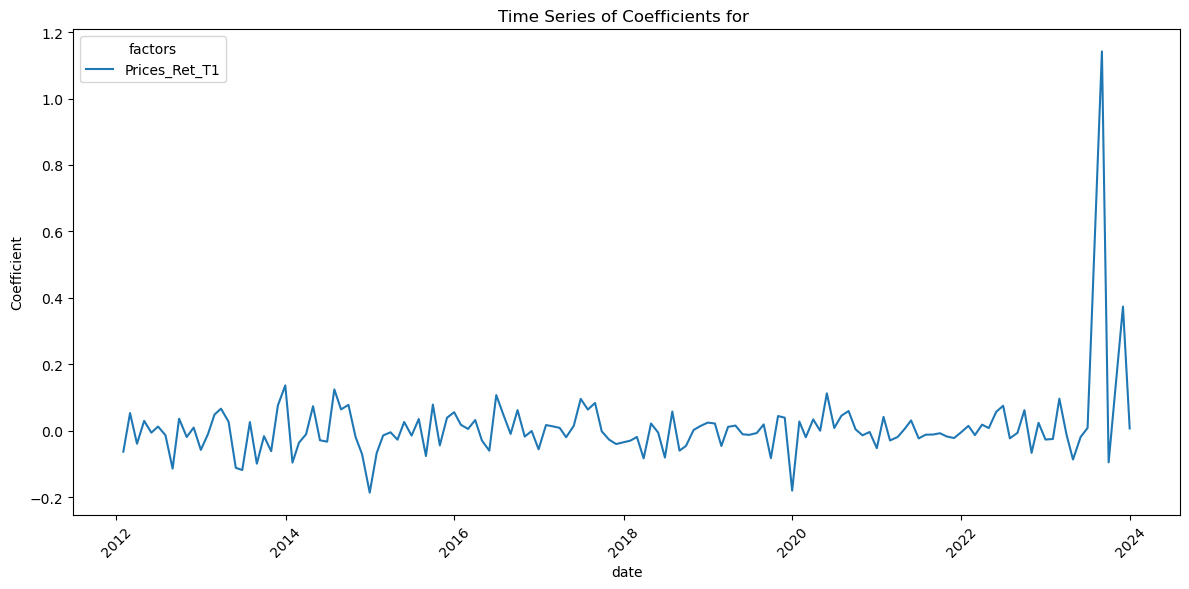

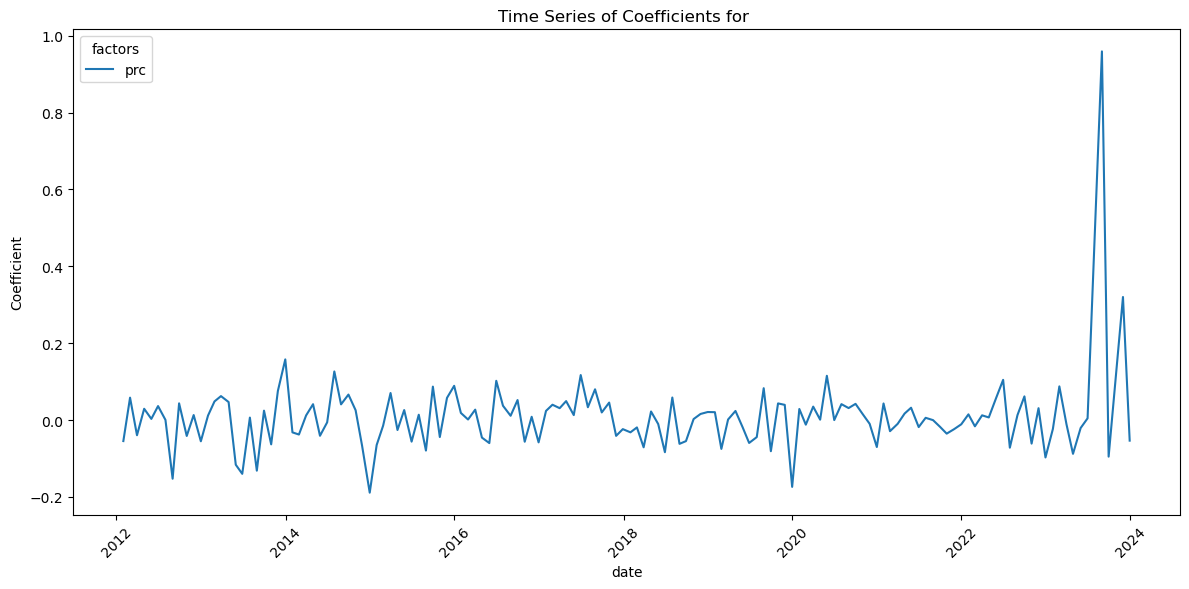

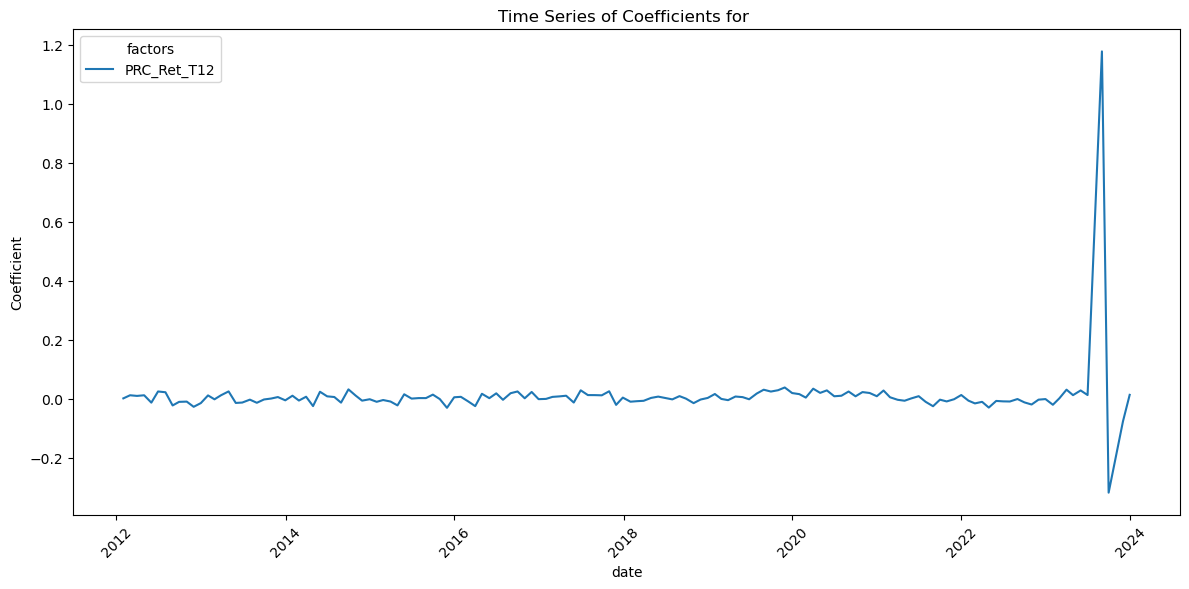

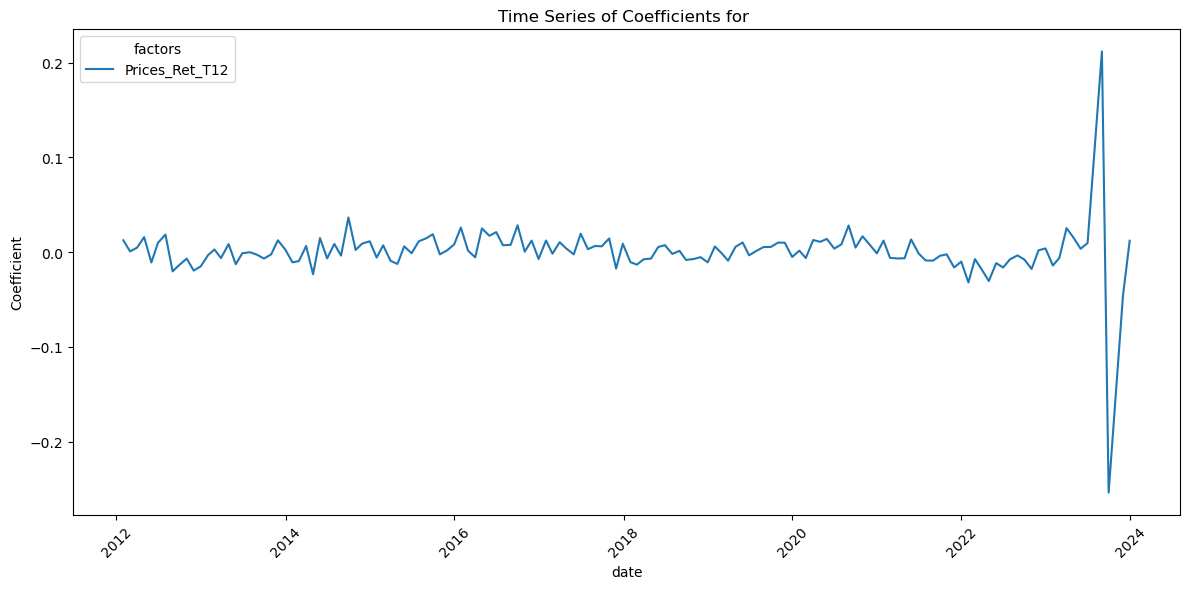

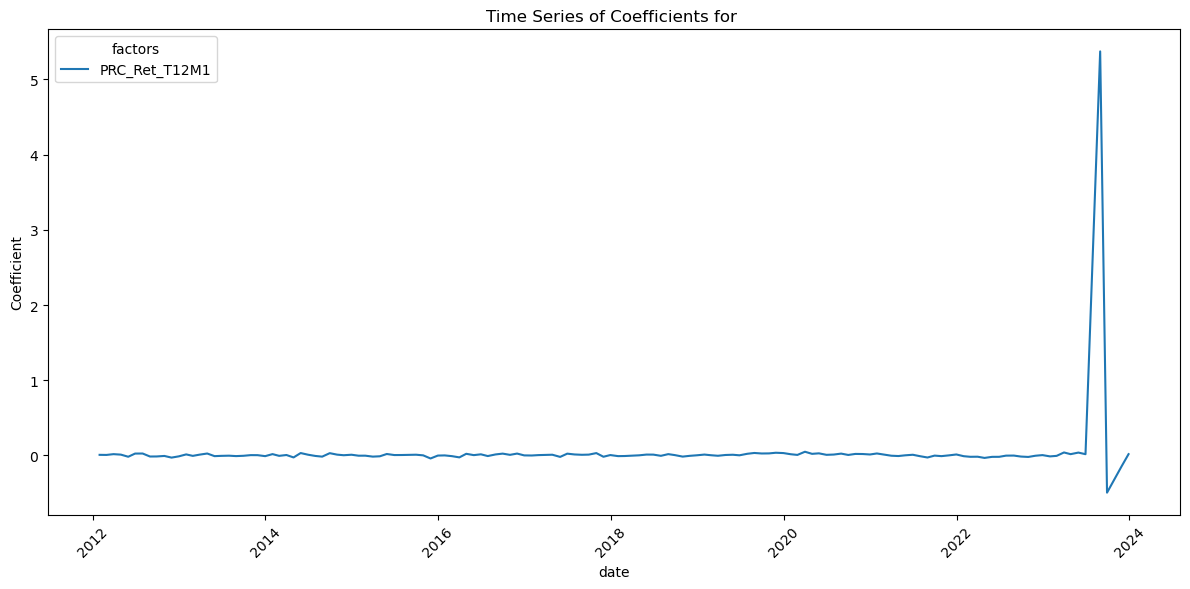

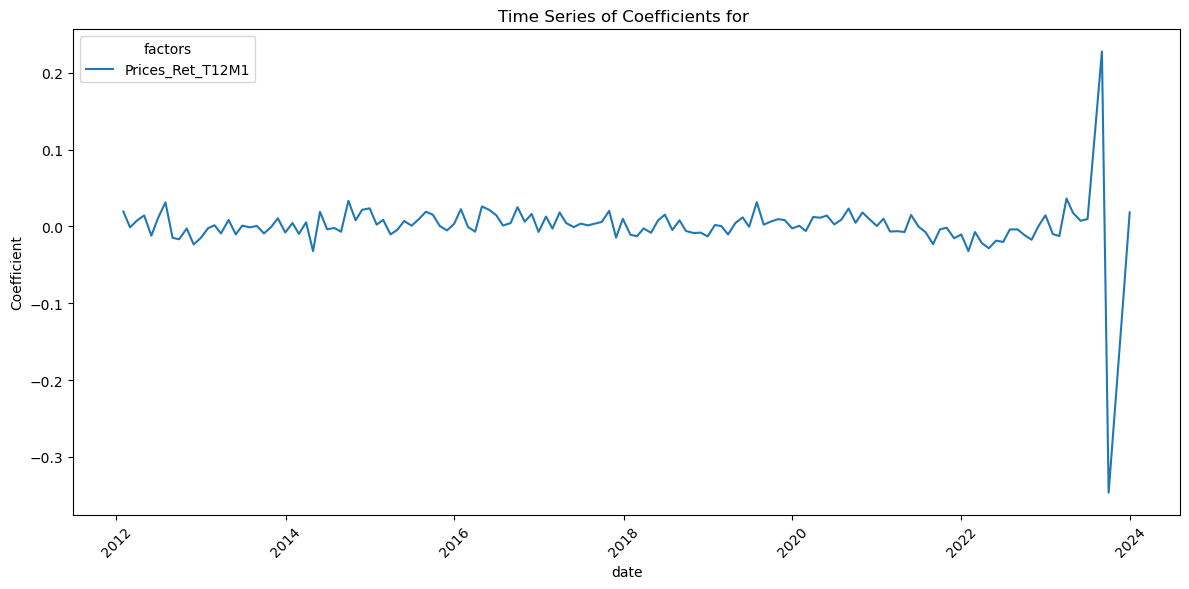

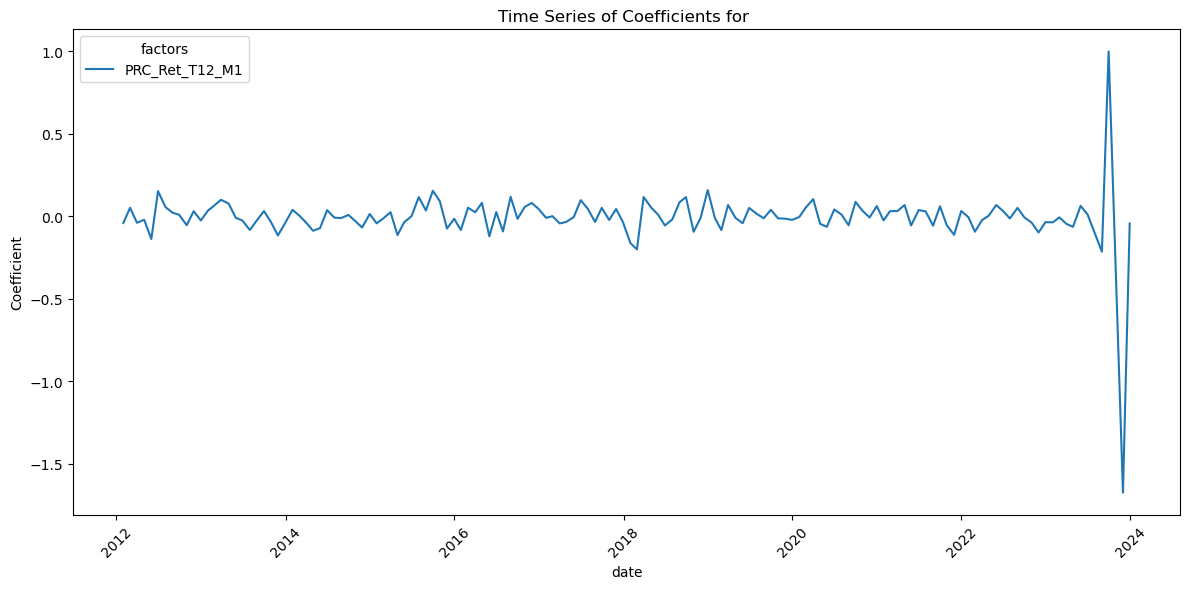

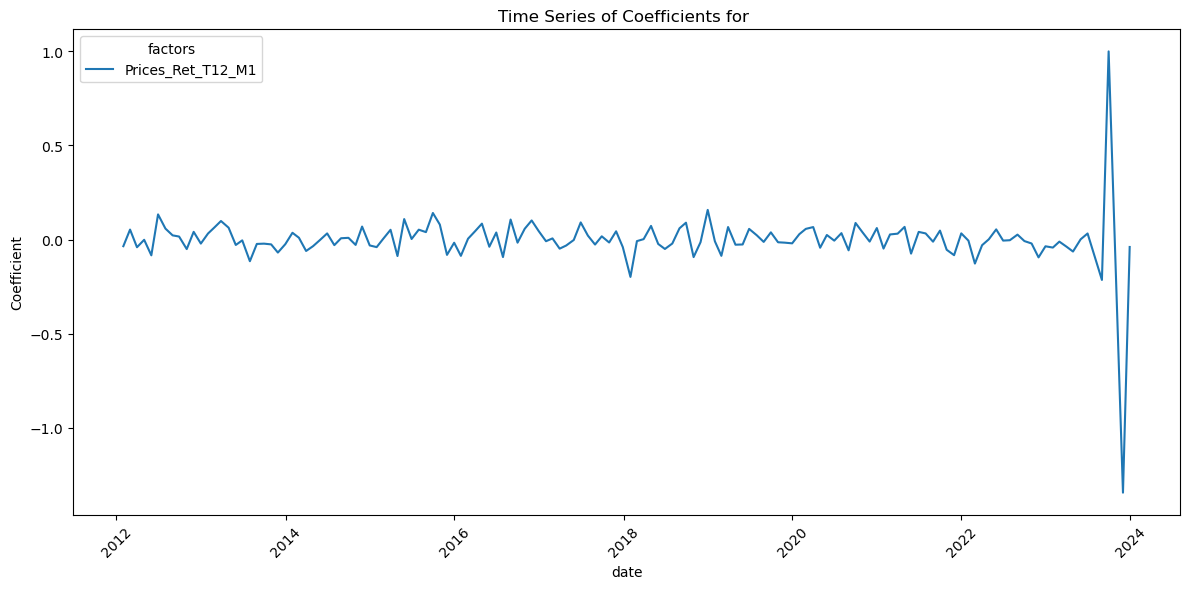

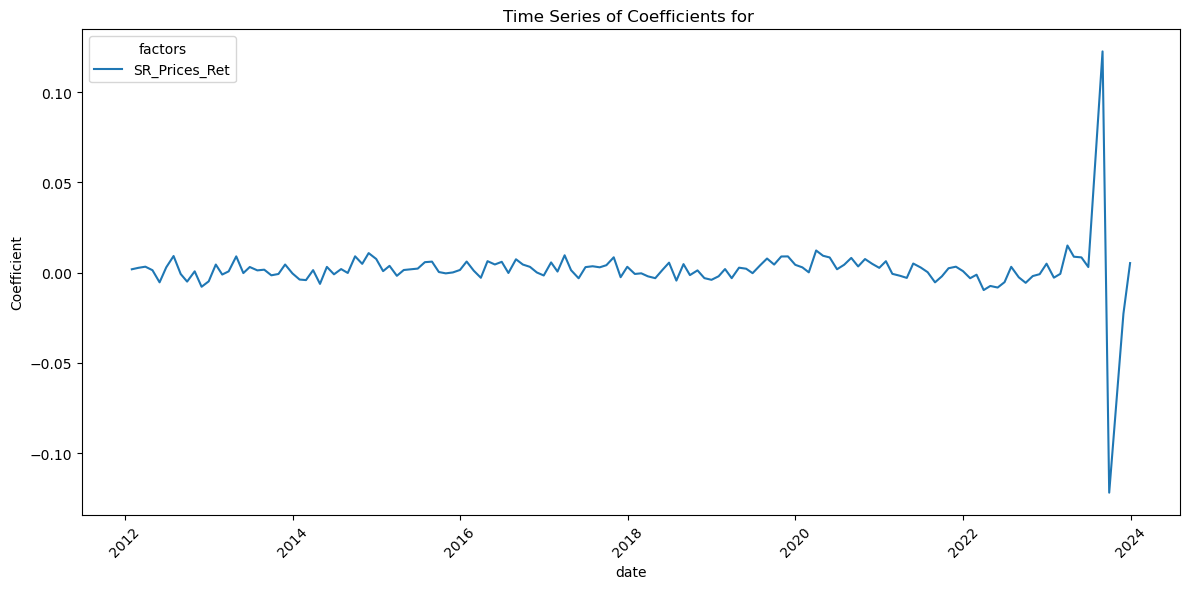

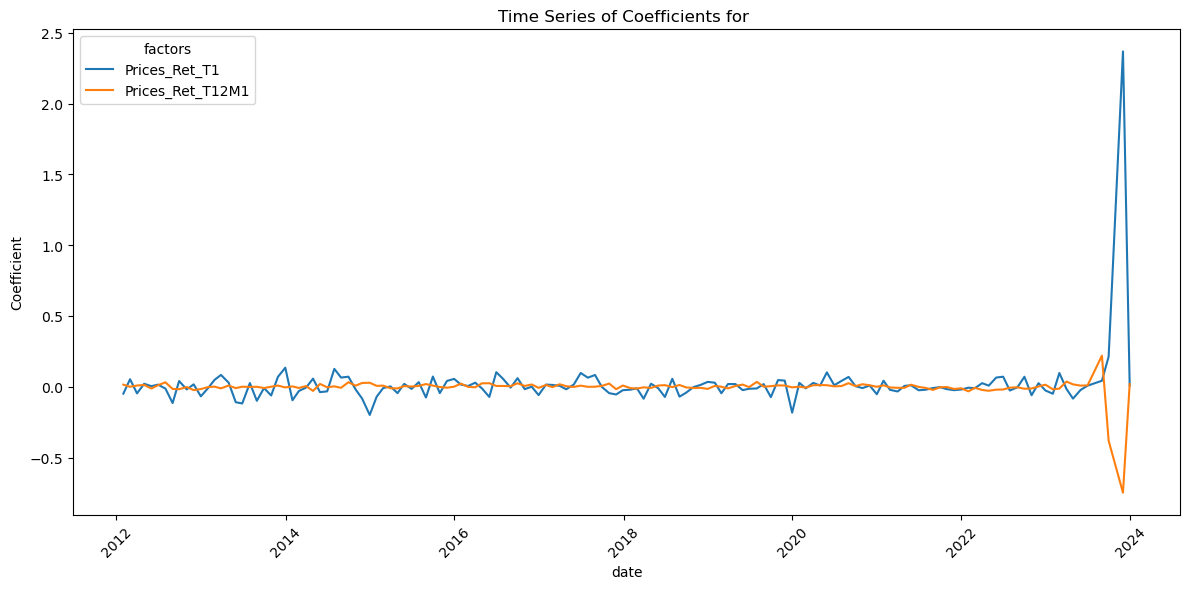

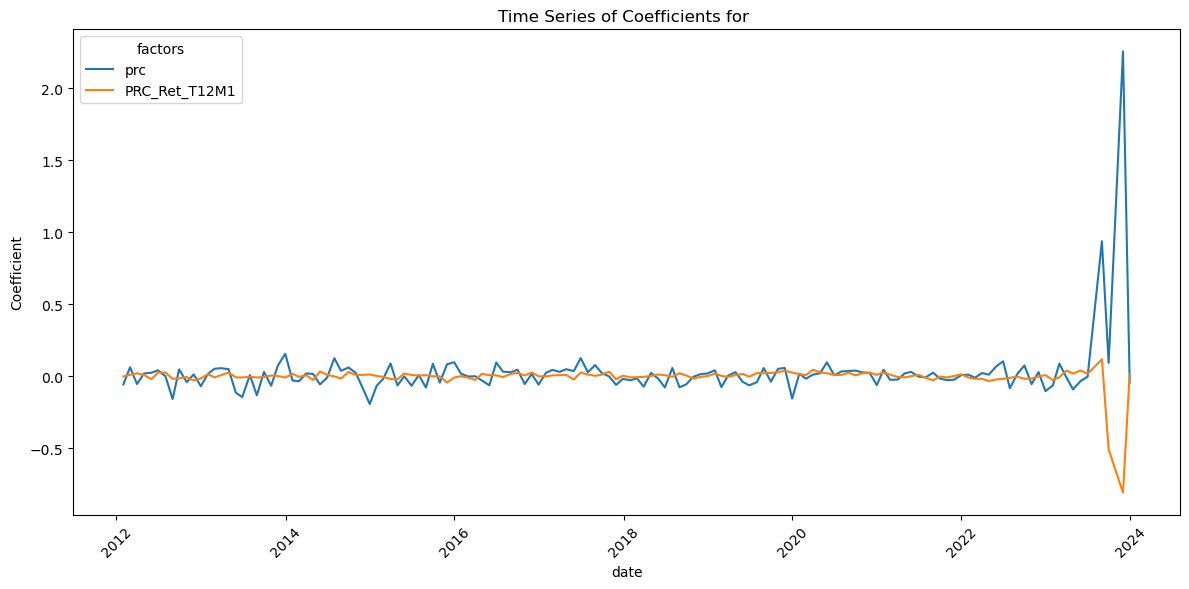

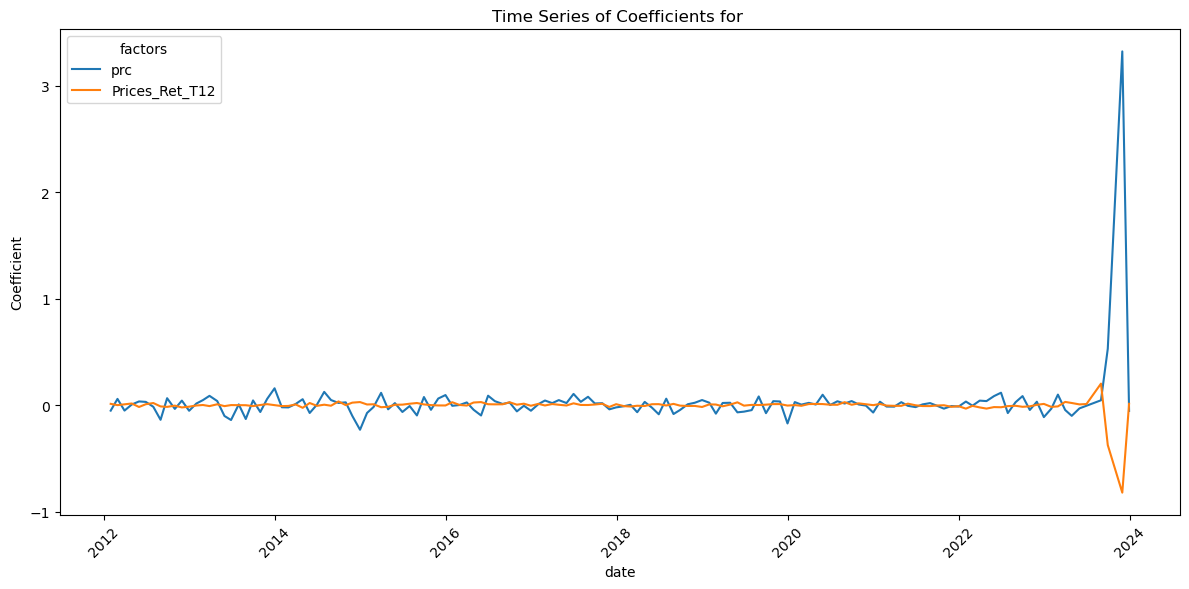

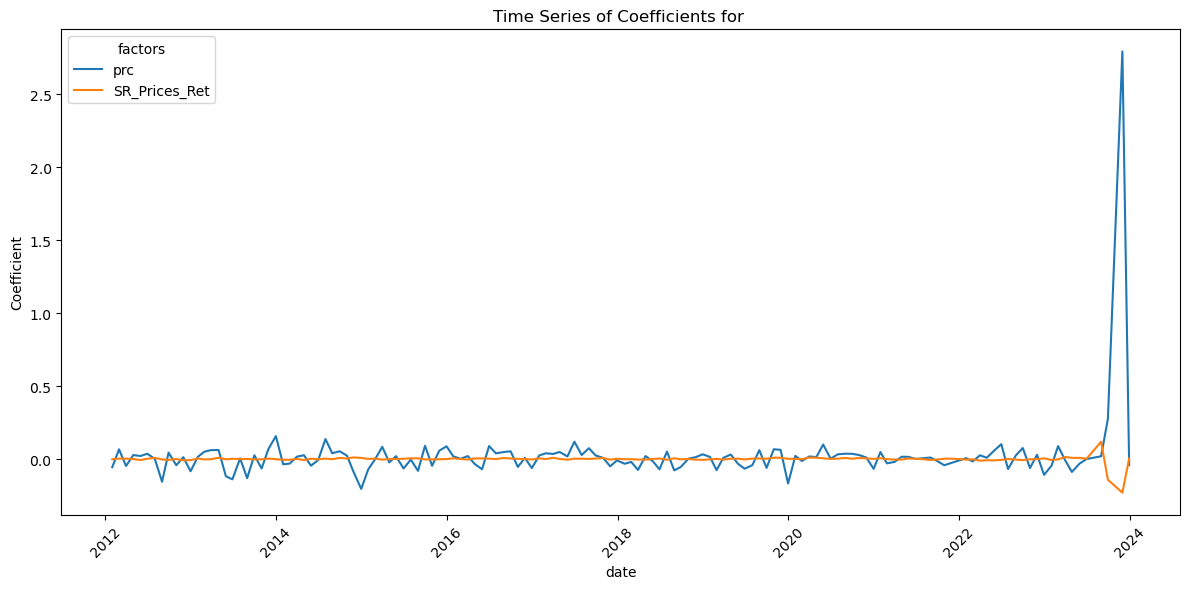

In [34]:
for i in iv_list:
    regression(DF=result_df_q8,dv='PRC_Ret_F1M',iv = i)

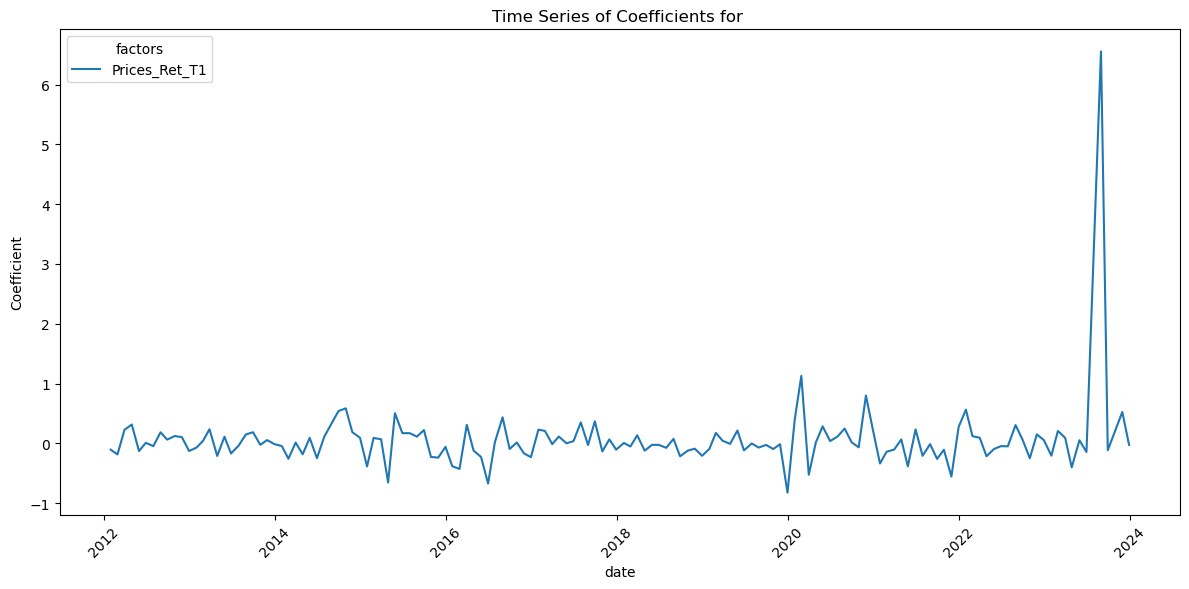

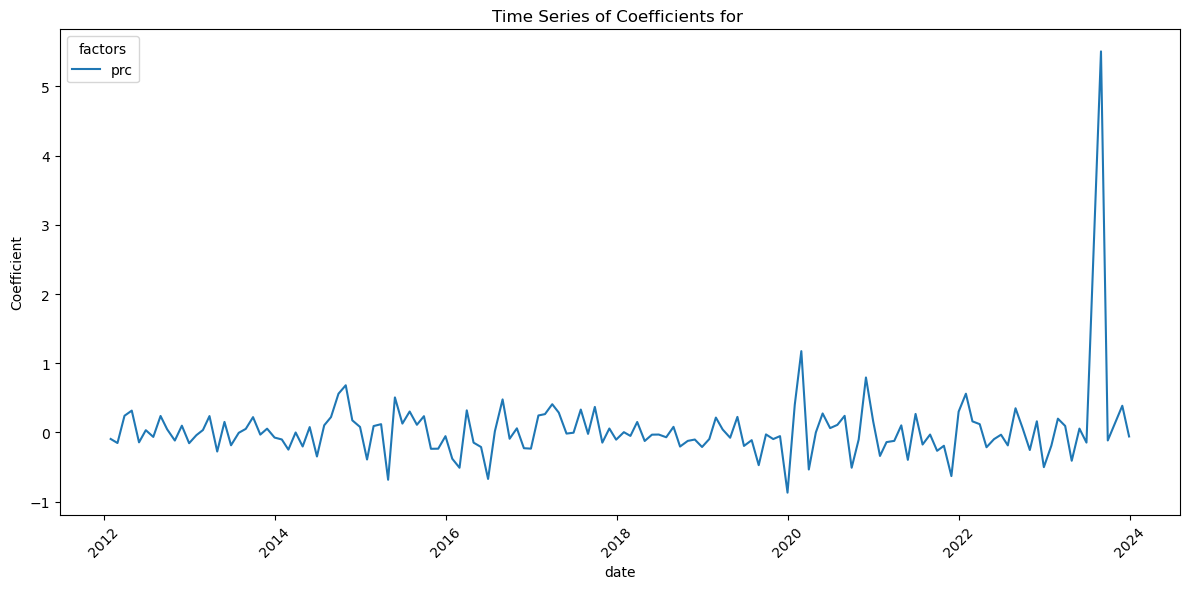

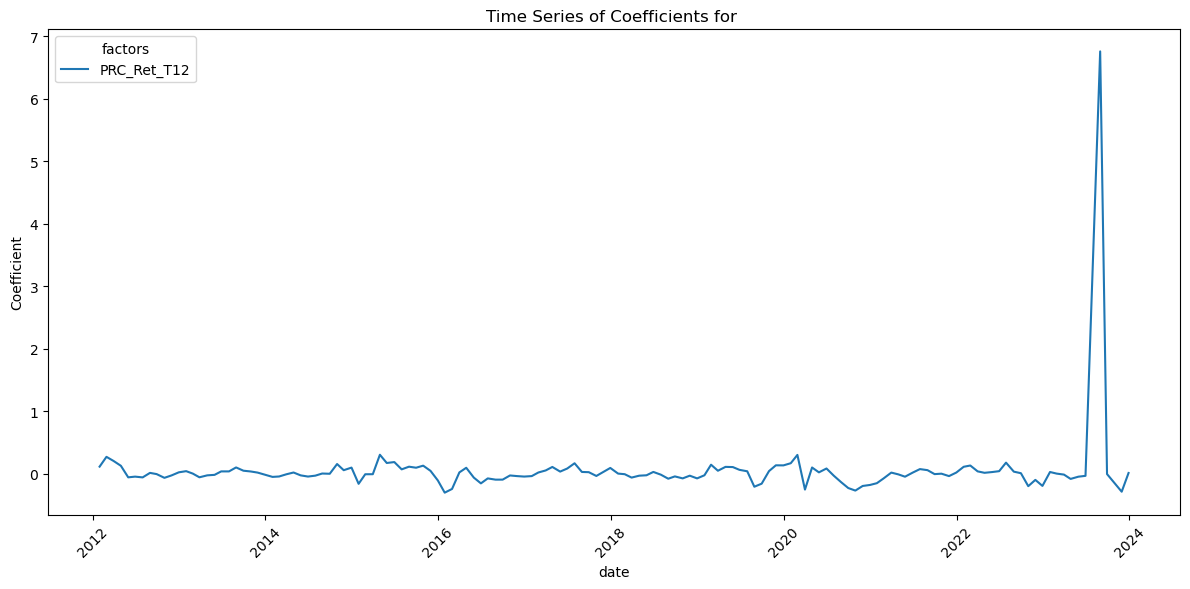

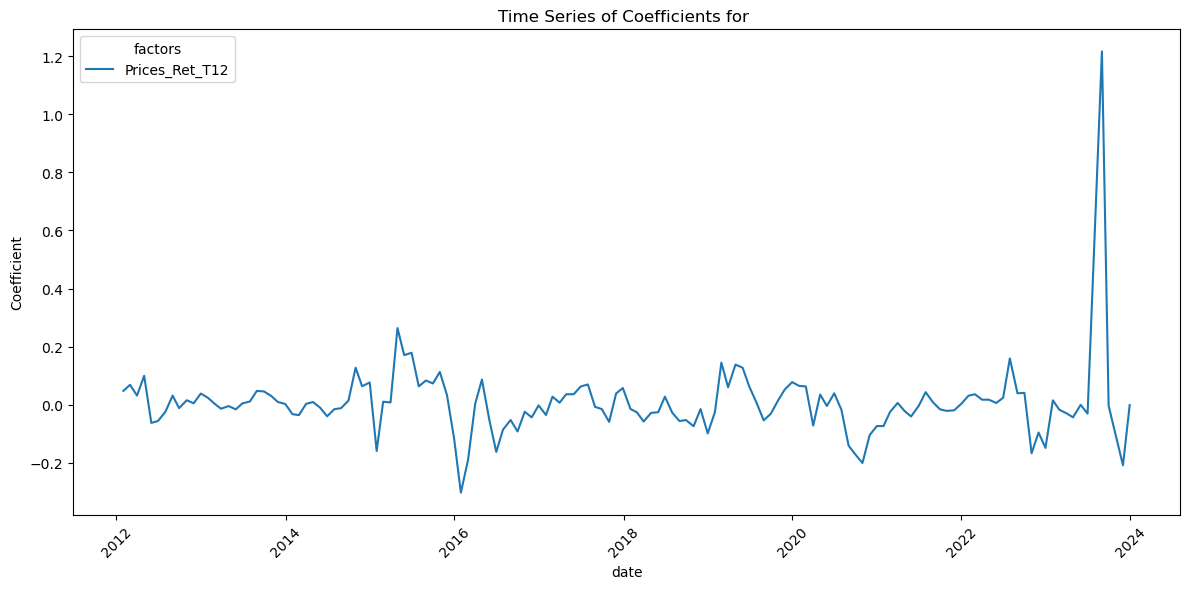

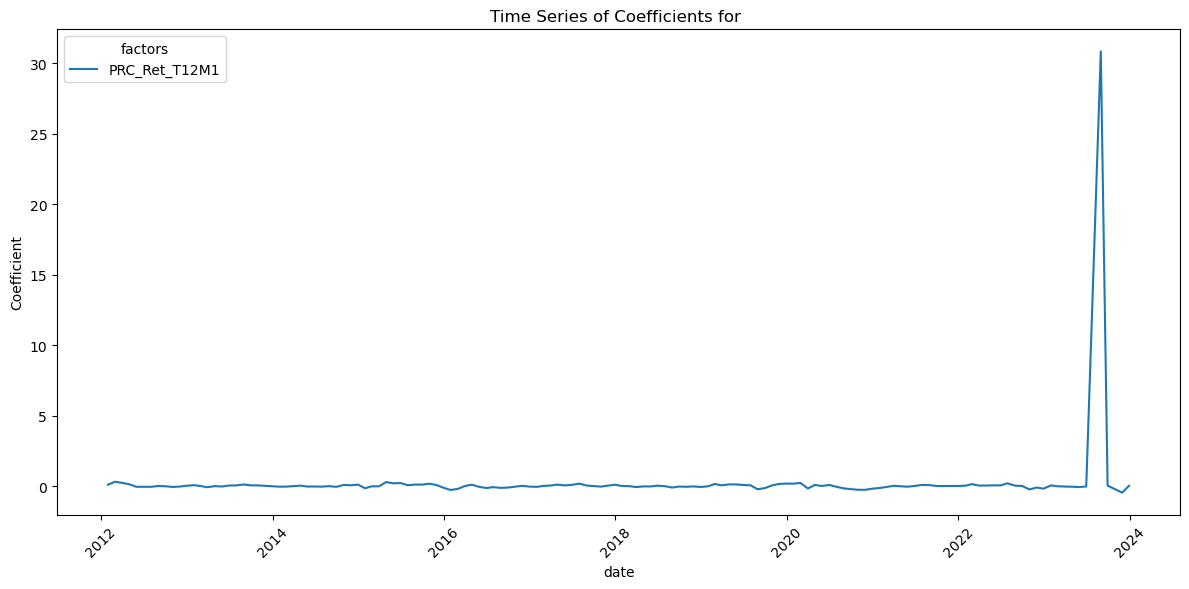

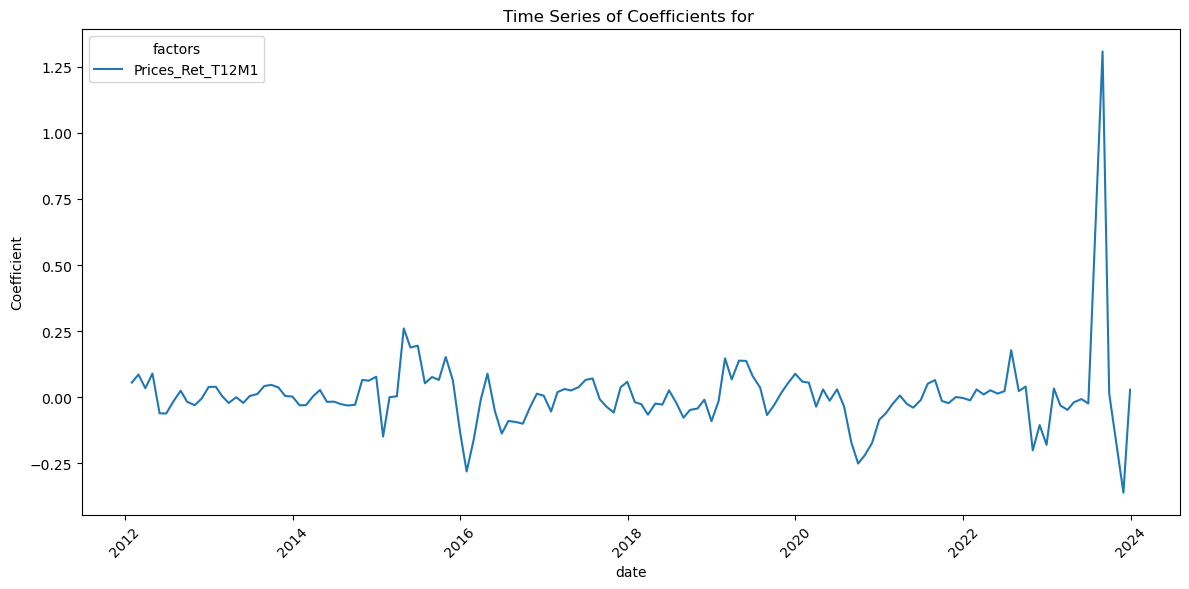

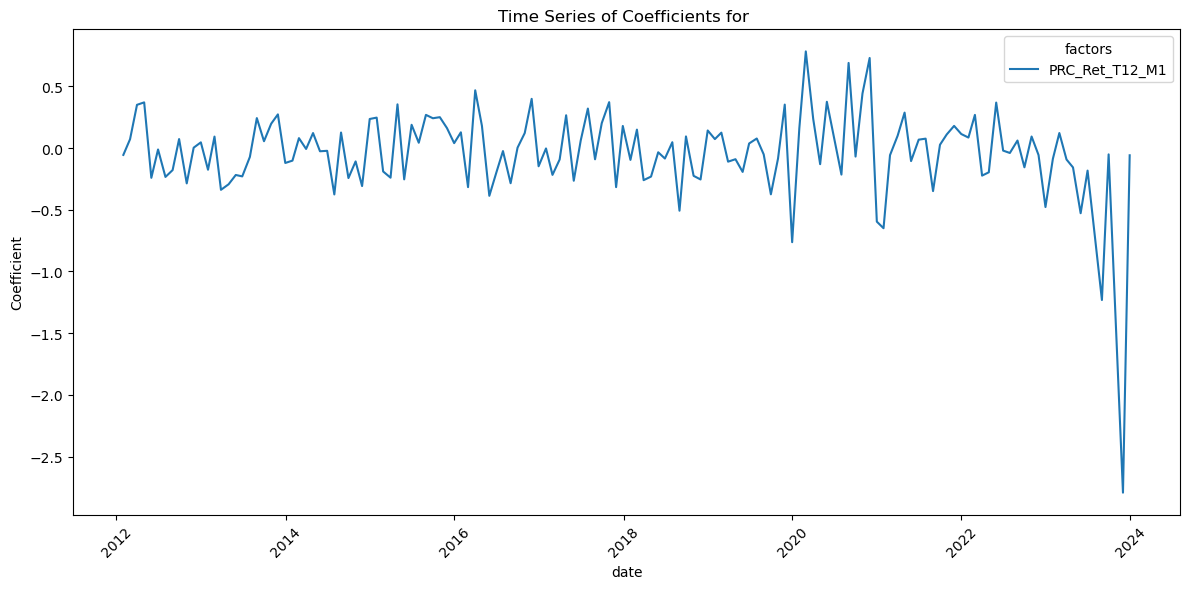

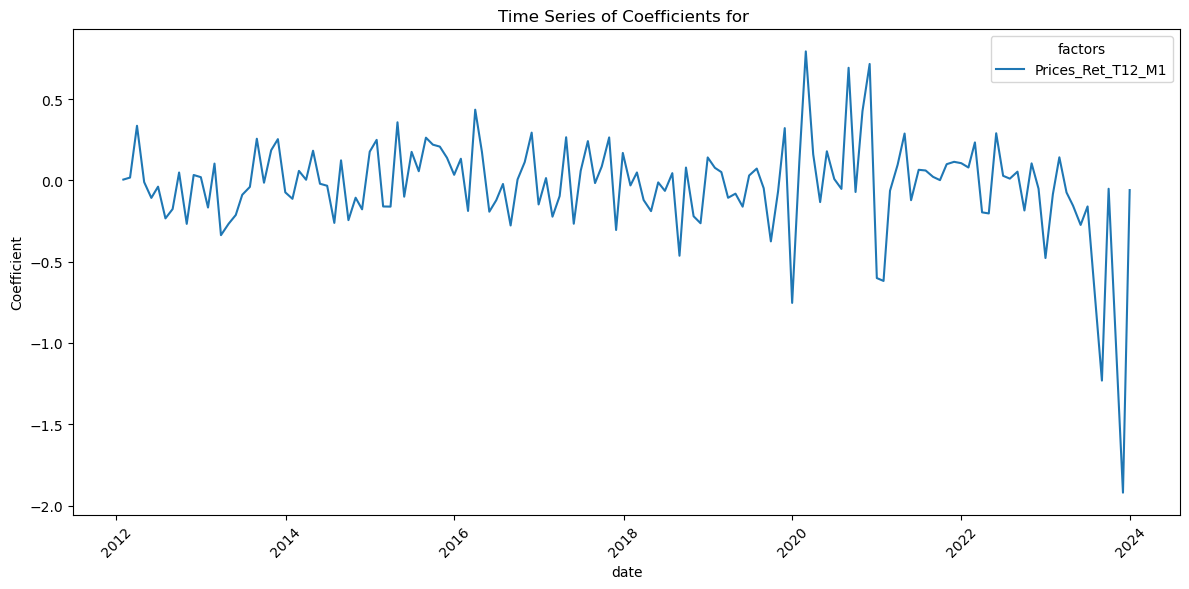

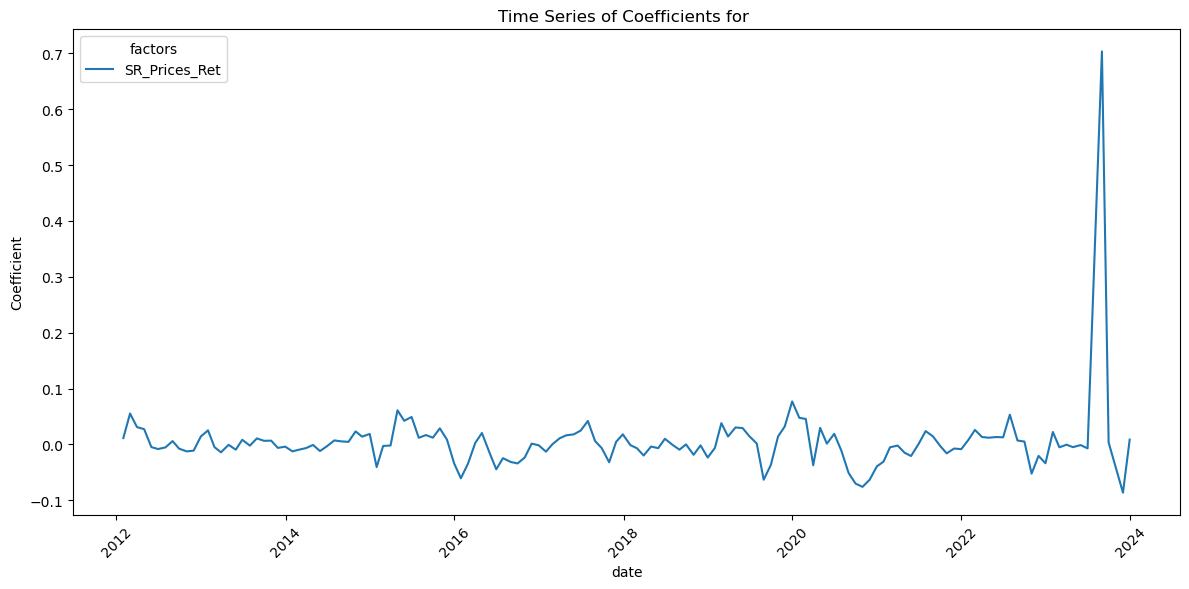

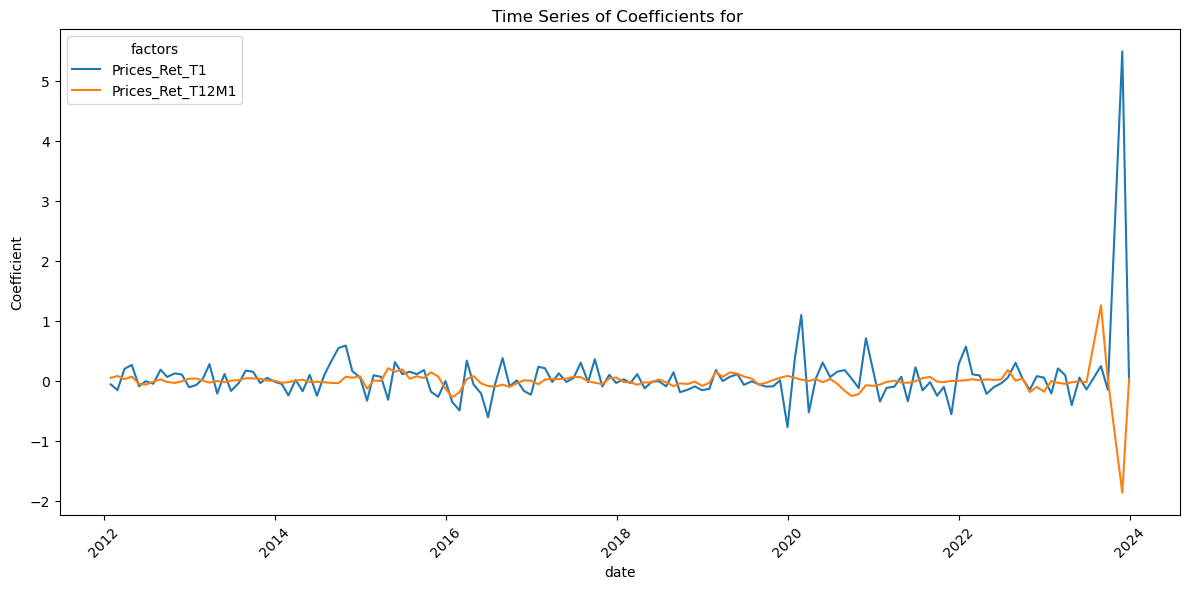

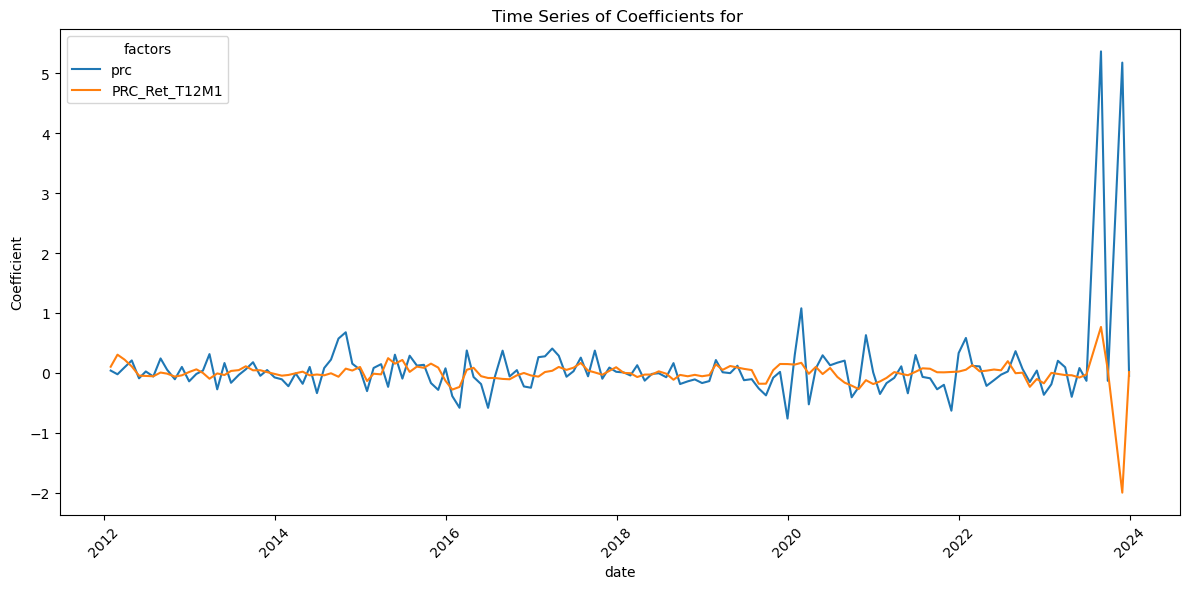

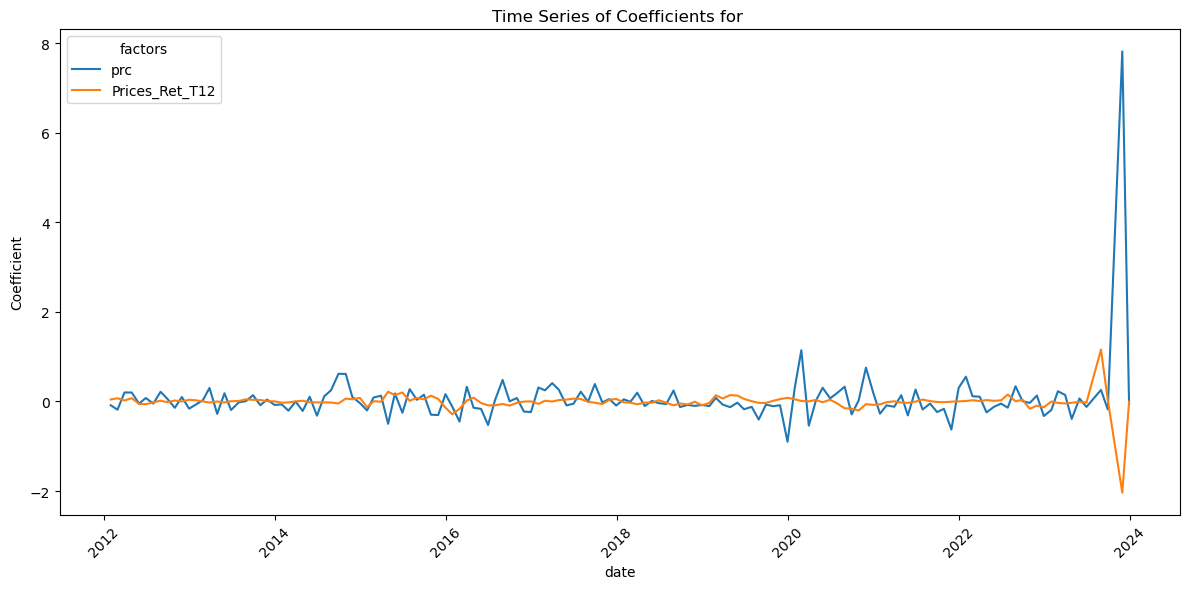

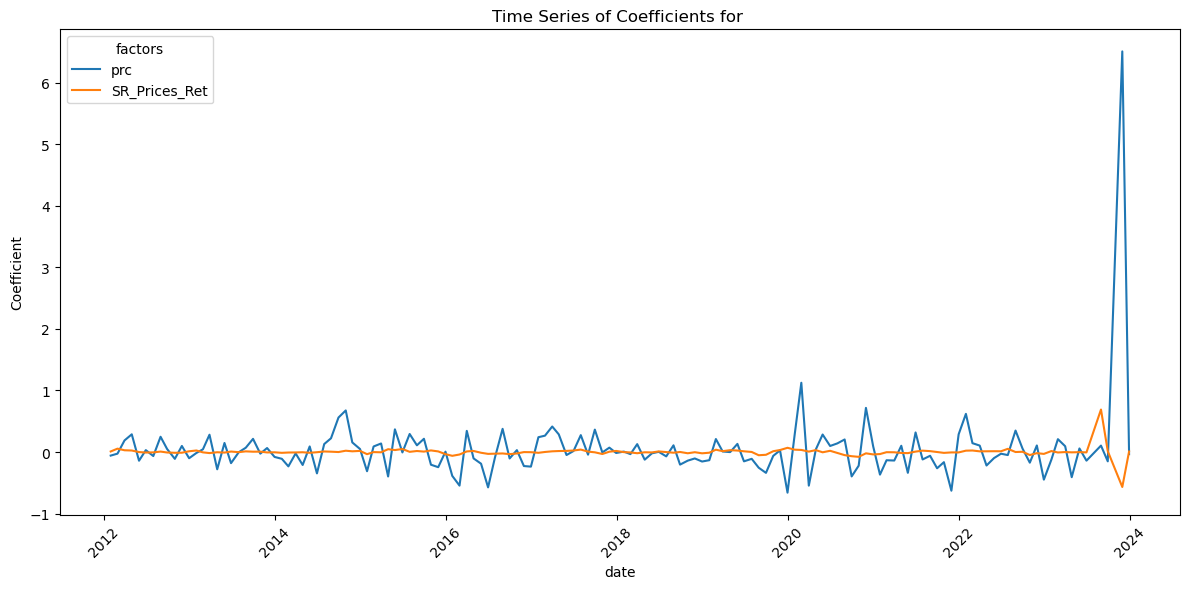

In [35]:
for i in iv_list:
    regression(DF=result_df_q8,dv='PRC_Ret_F3M',iv = i)

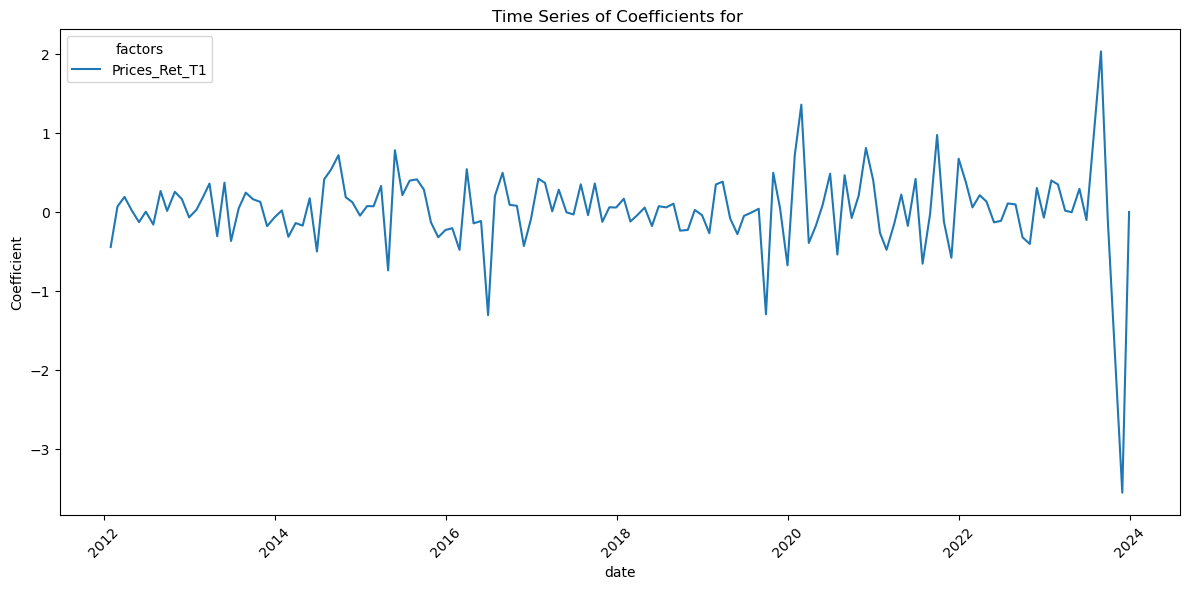

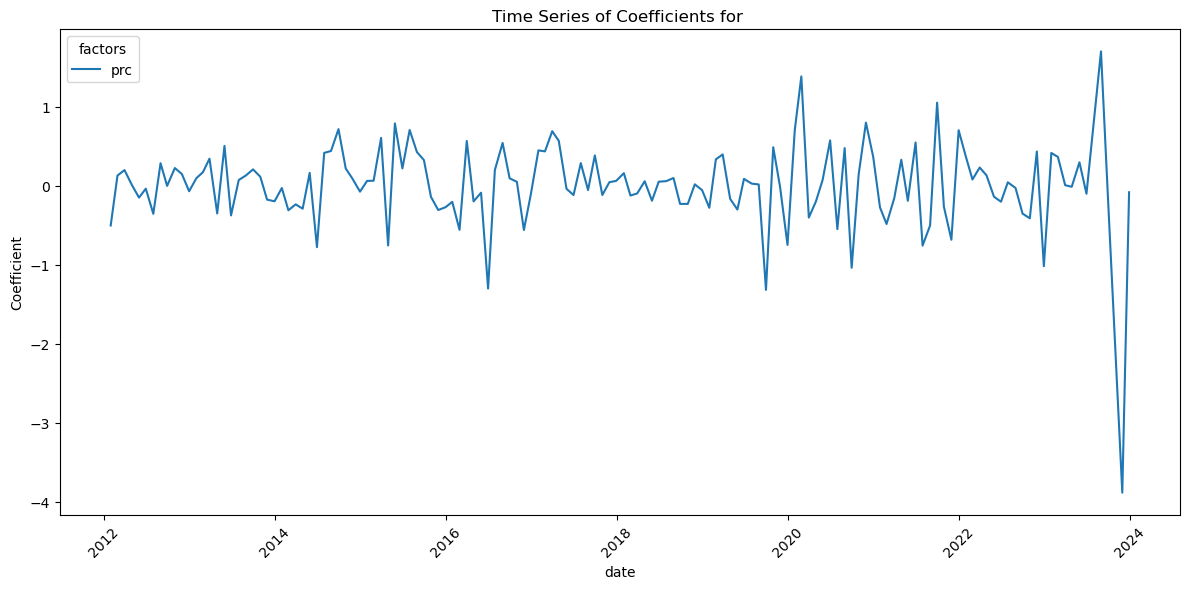

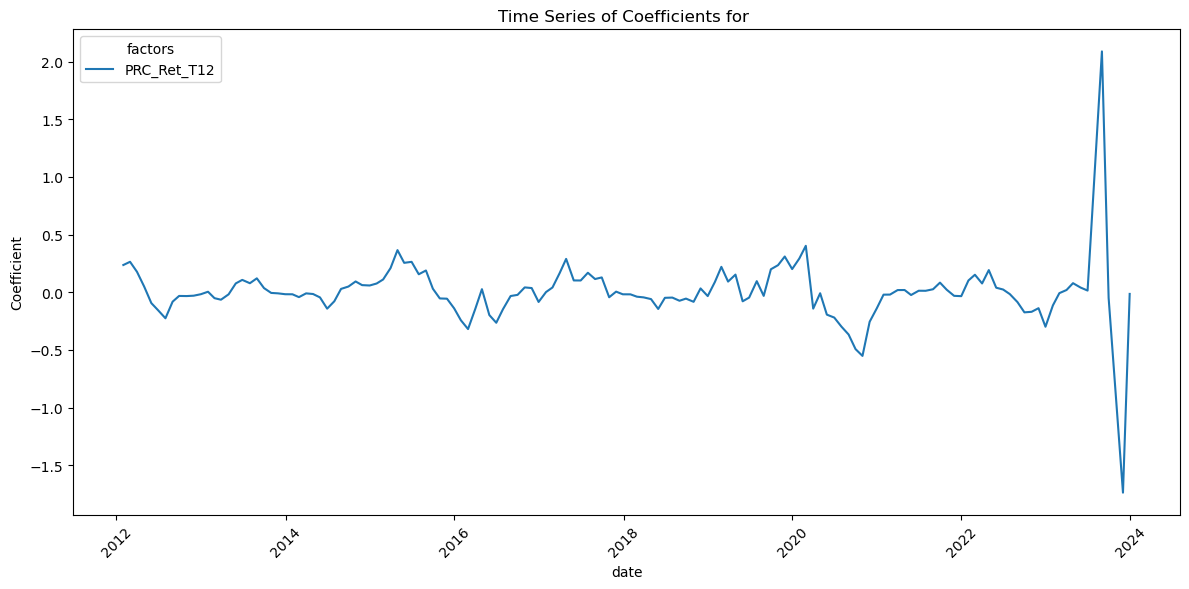

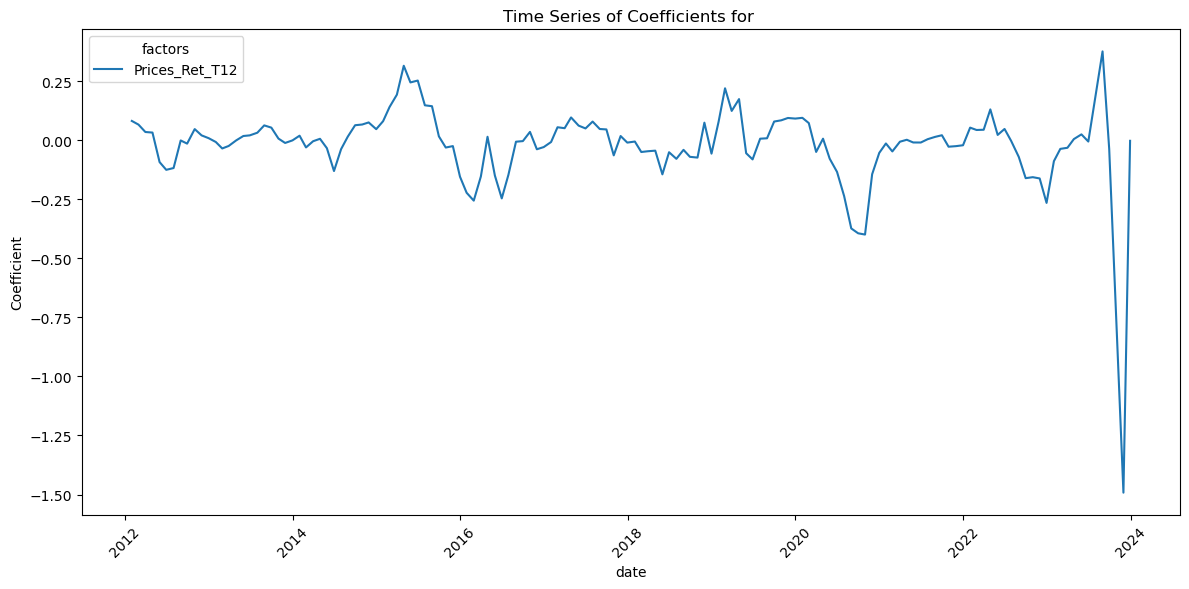

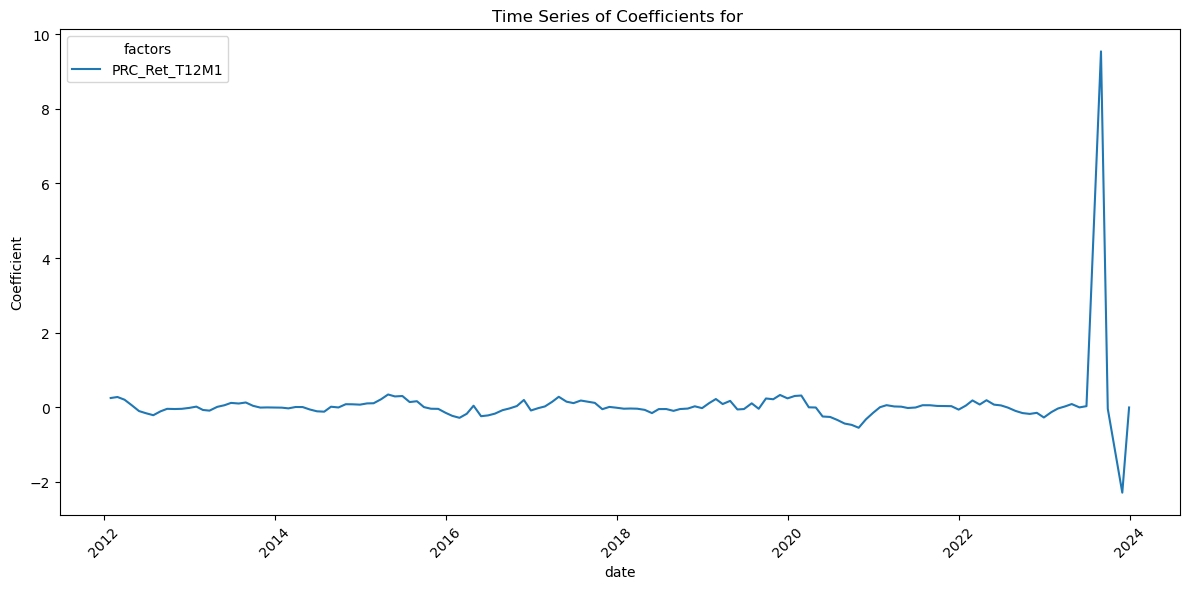

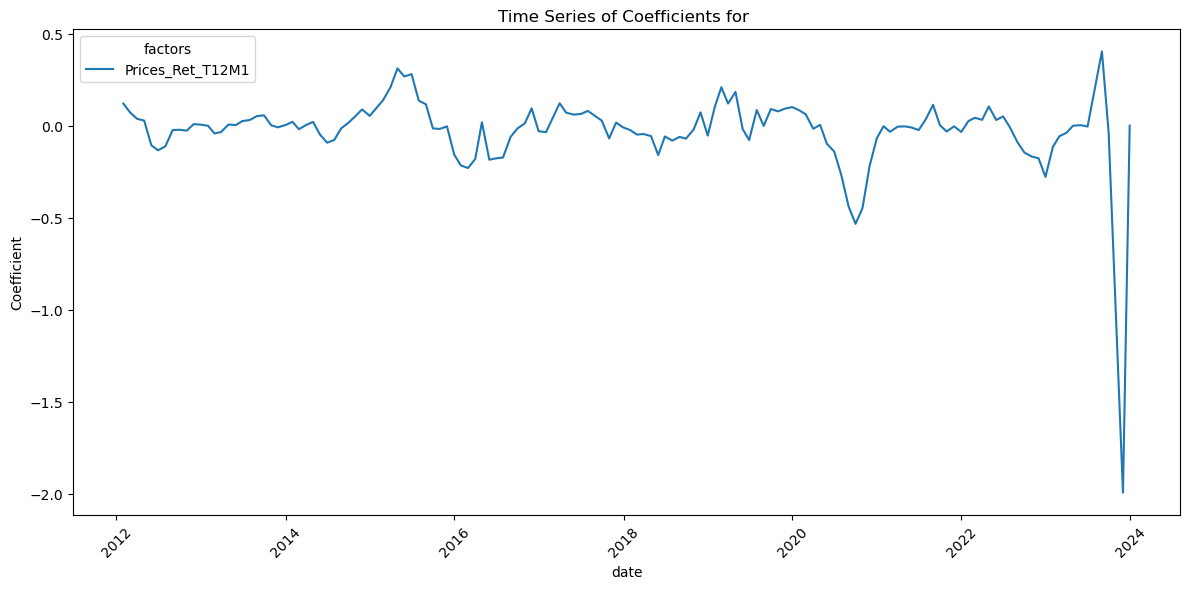

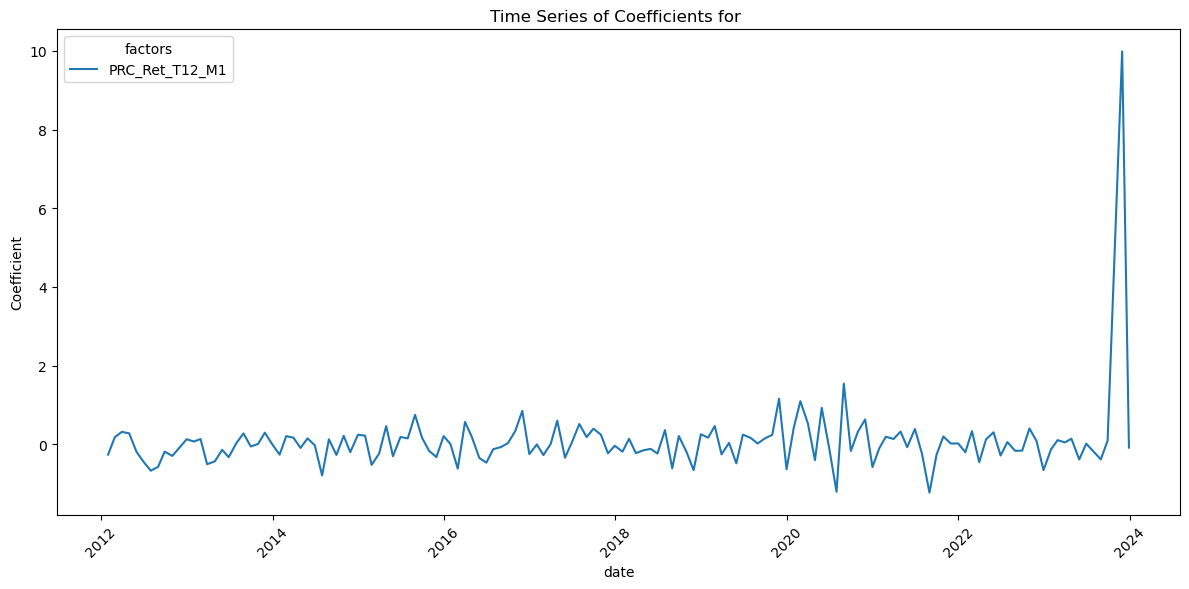

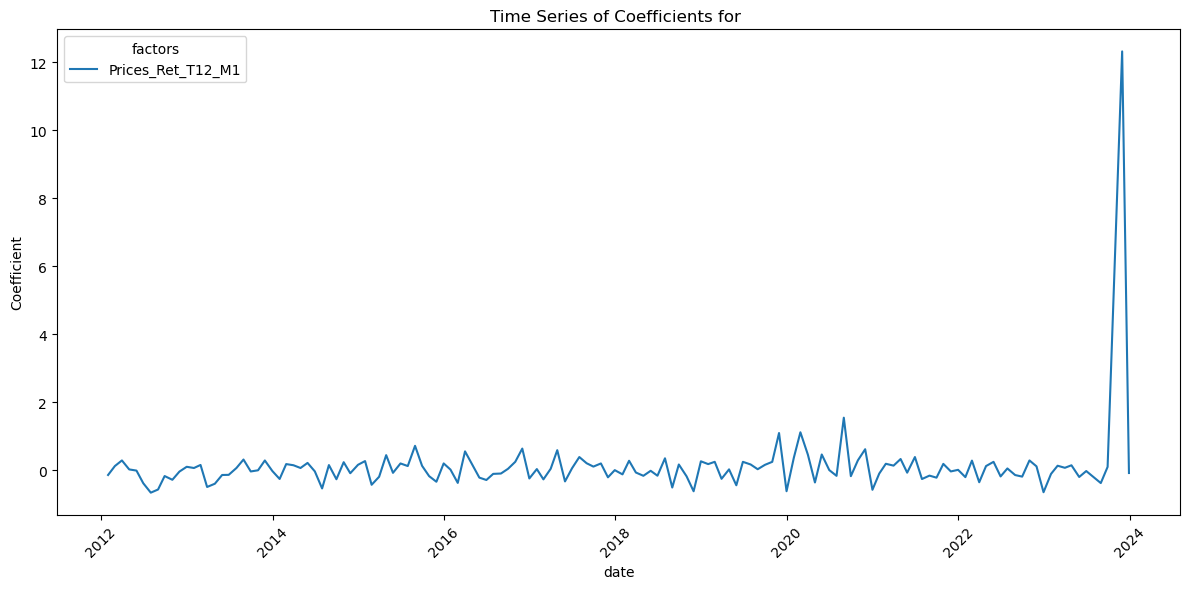

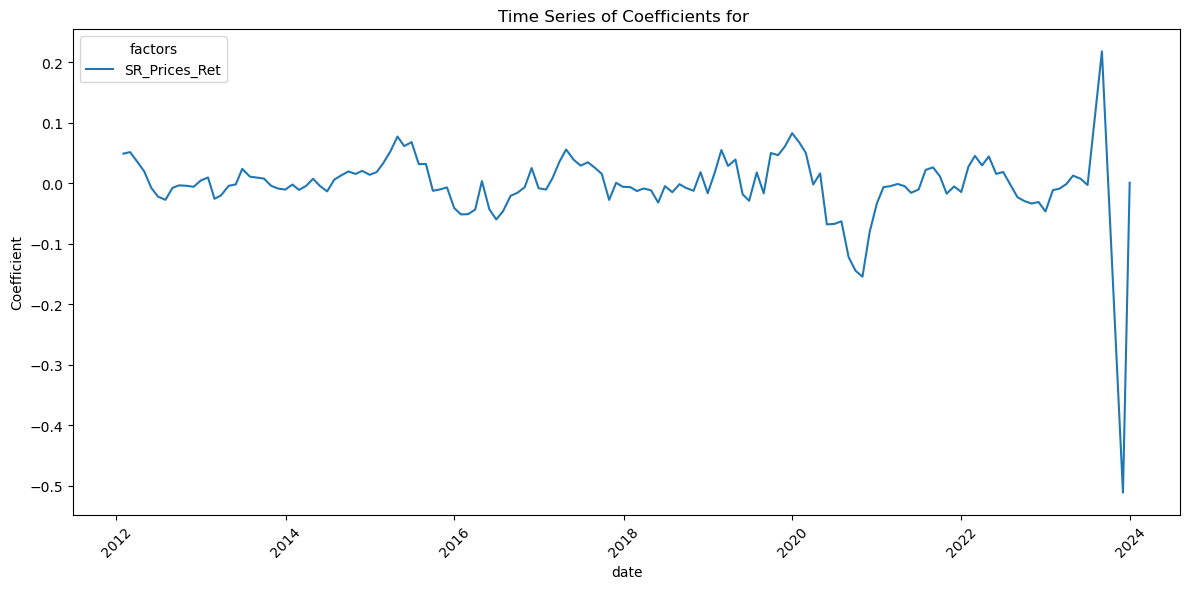

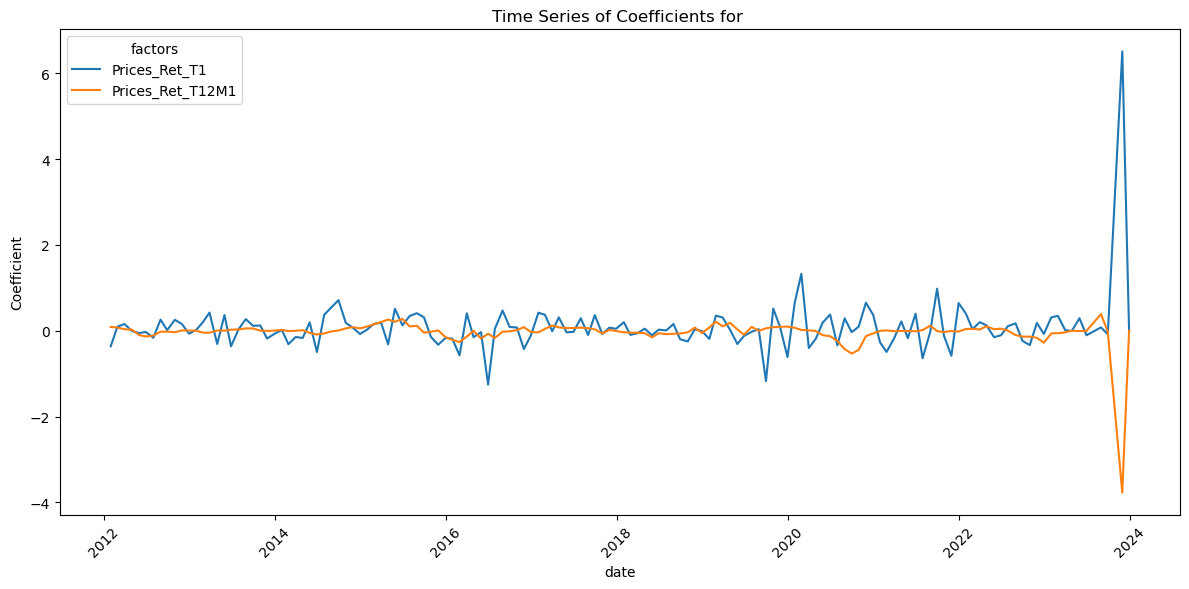

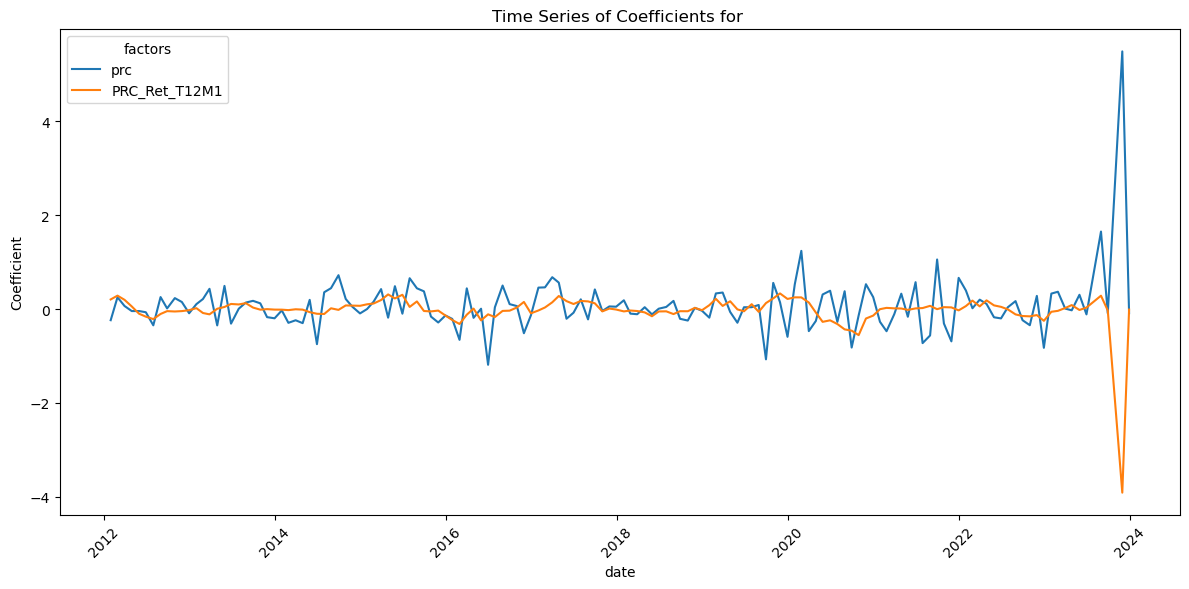

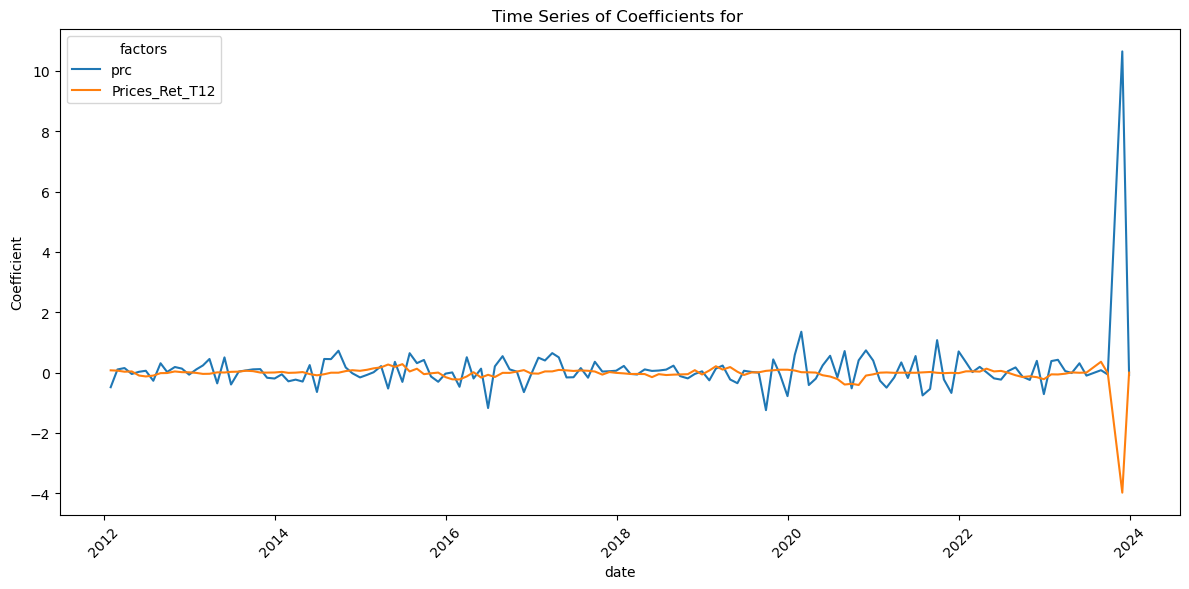

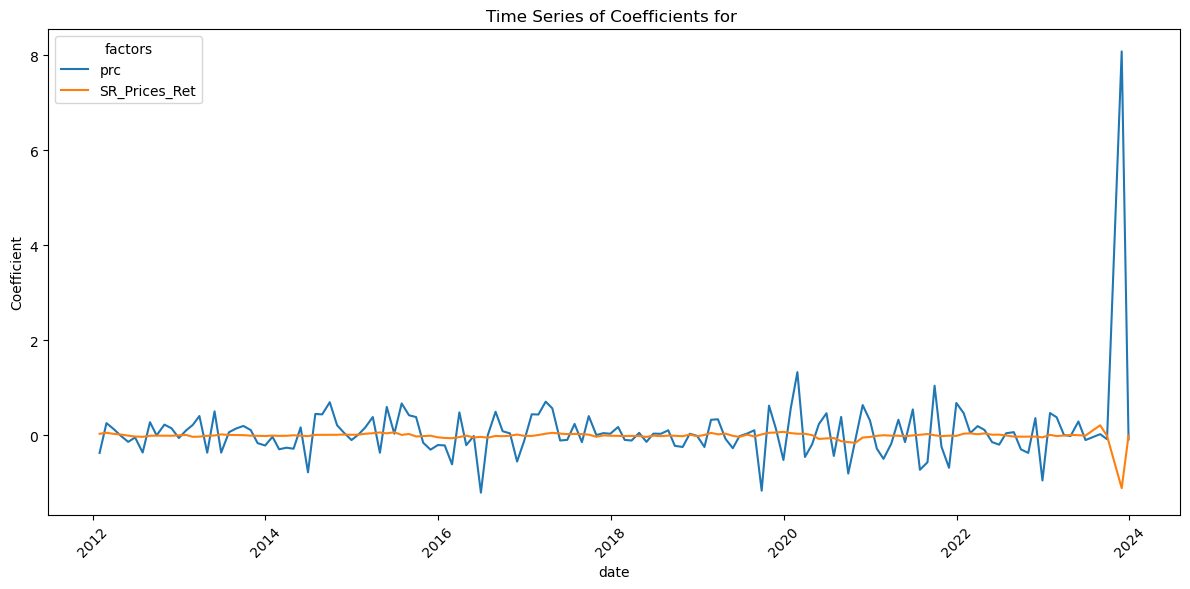

In [36]:
for i in iv_list:
    regression(DF=result_df_q8,dv='PRC_Ret_F6M',iv = i)

In [37]:
# Given list of regression lists
F1M_reg_list = [
    ['PRC_Ret_F1M', 'Prices_Ret_T1'],
    ['PRC_Ret_F1M', 'prc'],
    ['PRC_Ret_F1M', 'PRC_Ret_T12'],
    ['PRC_Ret_F1M', 'Prices_Ret_T12'],
    ['PRC_Ret_F1M', 'PRC_Ret_T12M1'],
    ['PRC_Ret_F1M', 'Prices_Ret_T12M1'],
    ['PRC_Ret_F1M', 'PRC_Ret_T12_M1'],
    ['PRC_Ret_F1M', 'Prices_Ret_T12_M1'],
    ['PRC_Ret_F1M', 'SR_Prices_Ret'],
    ['PRC_Ret_F1M', 'Prices_Ret_T1', 'Prices_Ret_T12M1'],
    ['PRC_Ret_F1M', 'prc', 'PRC_Ret_T12M1'],
    ['PRC_Ret_F1M', 'prc', 'Prices_Ret_T12'],
    ['PRC_Ret_F1M', 'prc', 'SR_Prices_Ret']
]


replacements = ['PRC_Ret_F3M', 'PRC_Ret_F6M']

F3M_reg_list = [list(map(lambda x: replacements[0] if x == 'PRC_Ret_F1M' else x, sublist)) for sublist in F1M_reg_list]
F6M_reg_list = [list(map(lambda x: replacements[1] if x == 'PRC_Ret_F1M' else x, sublist)) for sublist in F1M_reg_list]



In [38]:
FamaMacBeth_summary(DF=result_df_q8.set_index(['permno','date']).dropna(subset='PRC_Ret_F1M'),reg_lst=F1M_reg_list,reg_order=[])

(1)       (2)       (3)       (4)       (5)  \
const                0.011***  0.011***  0.010***  0.010***  0.010***   
const_t               (28.79)   (27.28)   (24.47)   (27.45)   (23.64)   
Prices_Ret_T1          -0.000                                           
Prices_Ret_T1_t       (-0.07)                                           
prc                               0.001                                 
prc_t                            (0.16)                                 
PRC_Ret_T12                               0.004**                       
PRC_Ret_T12_t                              (2.27)                       
Prices_Ret_T12                                        0.001             
Prices_Ret_T12_t                                     (0.78)             
PRC_Ret_T12M1                                                 0.005**   
PRC_Ret_T12M1_t                                                (2.47)   
Prices_Ret_T12M1                                                        
Prices_Ret_T12M1_t                                                      
PRC_Ret_T12_M1                                                          
PRC_Ret_T12_M1_t                                                        
Prices_Ret_T12_M1                                                       
Prices_Ret_T12_M1_t                                                     
SR_Prices_Ret                                                           
SR_Prices_Ret_t                                                         
No. Obs.                77678     78398     70206     70243     70898   
Adj. R²                 0.01%    -0.00%     0.02%    -0.02%     0.04%   

                          (6)       (7)       (8)       (9)      (10)  \
const                0.010***  0.011***  0.010***  0.010***  0.011***   
const_t               (26.80)   (28.47)   (26.89)   (25.00)   (23.80)   
Prices_Ret_T1                                                  -0.003   
Prices_Ret_T1_t                                               (-0.67)   
prc                                                                     
prc_t                                                                   
PRC_Ret_T12                                                             
PRC_Ret_T12_t                                                           
Prices_Ret_T12                                                          
Prices_Ret_T12_t                                                        
PRC_Ret_T12M1                                                           
PRC_Ret_T12M1_t                                                         
Prices_Ret_T12M1        0.002                                   0.002   
Prices_Ret_T12M1_t     (1.64)                                  (1.48)   
PRC_Ret_T12_M1                    0.002                                 
PRC_Ret_T12_M1_t                 (0.32)                                 
Prices_Ret_T12_M1                           0.002                       
Prices_Ret_T12_M1_t                        (0.50)                       
SR_Prices_Ret                                      0.002***             
SR_Prices_Ret_t                                      (3.31)             
No. Obs.                70974     70206     69517     70968     70974   
Adj. R²                 0.00%     0.00%     0.00%     0.01%     0.01%   

                         (11)      (12)      (13)  
const                0.010***  0.011***  0.010***  
const_t               (21.44)   (23.68)   (21.53)  
Prices_Ret_T1                                      
Prices_Ret_T1_t                                    
prc                    -0.002    -0.002    -0.002  
prc_t                 (-0.33)   (-0.32)   (-0.38)  
PRC_Ret_T12                                        
PRC_Ret_T12_t                                      
Prices_Ret_T12                    0.001            
Prices_Ret_T12_t                 (0.62)            
PRC_Ret_T12M1         0.004**                      
PRC_Ret_T12M1_t        (2.12)             

# Q9

In [39]:
FamaMacBeth_summary(DF=result_df_q8.set_index(['permno','date']).dropna(subset='PRC_Ret_F3M'),reg_lst=F3M_reg_list,reg_order=[])

In [ ]:
FamaMacBeth_summary(DF=result_df_q8.set_index(['permno','date']).dropna(subset='PRC_Ret_F6M'),reg_lst=F6M_reg_list,reg_order=[])

(1)       (2)       (3)       (4)       (5)  \
const                0.063***  0.062***  0.061***  0.059***  0.075***   
const_t                (4.44)    (4.40)    (3.84)    (3.97)    (3.15)   
Prices_Ret_T1           0.027                                           
Prices_Ret_T1_t        (0.83)                                           
prc                               0.013                                 
prc_t                            (0.35)                                 
PRC_Ret_T12                                 0.003                       
PRC_Ret_T12_t                              (0.12)                       
Prices_Ret_T12                                       -0.018             
Prices_Ret_T12_t                                    (-0.96)             
PRC_Ret_T12M1                                                   0.050   
PRC_Ret_T12M1_t                                                (0.81)   
Prices_Ret_T12M1                                                        
Prices_Ret_T12M1_t                                                      
PRC_Ret_T12_M1                                                          
PRC_Ret_T12_M1_t                                                        
Prices_Ret_T12_M1                                                       
Prices_Ret_T12_M1_t                                                     
SR_Prices_Ret                                                           
SR_Prices_Ret_t                                                         
No. Obs.                73928     74633     66605     66640     67283   
Adj. R²                 1.83%     2.14%     4.12%     2.72%     3.55%   

                          (6)       (7)       (8)       (9)     (10)     (11)  \
const                0.057***  0.067***  0.069***  0.057***  0.047**  0.043**   
const_t                (3.68)    (4.66)    (4.55)    (3.73)   (2.26)   (1.99)   
Prices_Ret_T1                                                  0.081            
Prices_Ret_T1_t                                               (1.61)            
prc                                                                     0.064   
prc_t                                                                  (1.41)   
PRC_Ret_T12                                                                     
PRC_Ret_T12_t                                                                   
Prices_Ret_T12                                                                  
Prices_Ret_T12_t                                                                
PRC_Ret_T12M1                                                          -0.028   
PRC_Ret_T12M1_t                                                       (-0.78)   
Prices_Ret_T12M1       -0.020                                 -0.035            
Prices_Ret_T12M1_t    (-1.03)                                (-1.19)            
PRC_Ret_T12_M1                    0.069                                         
PRC_Ret_T12_M1_t                 (0.93)                                         
Prices_Ret_T12_M1                           0.107                               
Prices_Ret_T12_M1_t                        (1.22)                               
SR_Prices_Ret                                        -0.003                     
SR_Prices_Ret_t                                     (-0.51)                     
No. Obs.                67353     66605     65931     67348    67353    67283   
Adj. R²                 2.20%     1.06%     0.82%     2.41%    3.30%    4.81%   

                        (12)     (13)  
const                0.044**  0.044**  
const_t               (1.99)   (2.03)  
Prices_Ret_T1                          
Prices_Ret_T1_t                        
prc                    0.108    0.085  
prc_t                 (1.39)   (1.38)  
PRC_Ret_T12                            
PRC_Ret_T12_t                          
Prices_Ret_T12        -0.038           
Prices_Ret_T12_t     (-1.21)           
PRC_Ret_T12M1                          
PR

In [ ]:
F1M_reg_list = [
    ['PRC_Ret_F1M', 'Prices_Ret_T1'],
    ['PRC_Ret_F1M', 'prc'],
    ['PRC_Ret_F1M', 'PRC_Ret_T12'],
    ['PRC_Ret_F1M', 'Prices_Ret_T12'],
    ['PRC_Ret_F1M', 'PRC_Ret_T12M1'],
    ['PRC_Ret_F1M', 'Prices_Ret_T12M1'],
    ['PRC_Ret_F1M', 'PRC_Ret_T12_M1'],
    ['PRC_Ret_F1M', 'Prices_Ret_T12_M1'],
    ['PRC_Ret_F1M', 'SR_Prices_Ret'],
    ['PRC_Ret_F1M', 'Prices_Ret_T1', 'Prices_Ret_T12M1'],
    ['PRC_Ret_F1M', 'prc', 'PRC_Ret_T12M1'],
    ['PRC_Ret_F1M', 'prc', 'Prices_Ret_T12'],
    ['PRC_Ret_F1M', 'prc', 'SR_Prices_Ret']
]

# 去除每个列表中的'PRC_Ret_F1M'
F1M_reg_list_rm = [[item for item in sublist if item != 'PRC_Ret_F1M'] for sublist in F1M_reg_list]

print(F1M_reg_list_rm)


[['Prices_Ret_T1'], ['prc'], ['PRC_Ret_T12'], ['Prices_Ret_T12'], ['PRC_Ret_T12M1'], ['Prices_Ret_T12M1'], ['PRC_Ret_T12_M1'], ['Prices_Ret_T12_M1'], ['SR_Prices_Ret'], ['Prices_Ret_T1', 'Prices_Ret_T12M1'], ['prc', 'PRC_Ret_T12M1'], ['prc', 'Prices_Ret_T12'], ['prc', 'SR_Prices_Ret']]
